# Air Pollution in Seoul

*The Korea Times. Seoul, Hàn Quốc. Được cung cấp bởi Kim Joon-hee*

Ai cũng biết rằng ô nhiễm không khí có thể gây ra một số vấn đề về môi trường và sức khỏe của chúng ta. Bức ảnh trên được chụp vào ngày 11 tháng 12 năm 2019 và cho thấy nó có thể tác động đến cảnh quan của Seoul như thế nào. Trong trường hợp này, một lớp sương mù bụi siêu mịn, bay từ tận Trung Quốc, kéo dài hai ngày và khiến chính quyền địa phương phải ban hành các biện pháp giảm phát thải khẩn cấp. Theo [The Korea Times](https://www.koreatimes.co.kr/www/nation/2020/02/281_280126.html), Trung tâm Dự báo Chất lượng Không khí, trực thuộc Bộ Môi trường, đã báo cáo rằng vào ngày 11 tháng 12 lúc 10 giờ tối, nồng độ các hạt PM2.5 là khoảng 118 microgam trên mét khối tại Seoul.

Với bối cảnh đó, mục đích trong nghiên cứu này là tìm hiểu và hình dung cách ô nhiễm không khí phân bố theo địa lý tại 25 quận tạo nên thủ đô của đất nước. Để làm như vậy, phân tích một tập dữ liệu chứa các bản ghi được thu thập theo giờ của sáu chất gây ô nhiễm (SO2, NO2, CO, O3, PM10, PM2.5) trong khoảng thời gian ba năm. Ở Seoul, mỗi quận đều có trạm riêng đo bộ chất gây ô nhiễm này, vì vậy có thể phân tích cả ô nhiễm nói chung và ô nhiễm phân theo khu vực.

## Import data và thư viện <a id ='importing-data'></a>

In [ ]:
# # Install Condacolab to integrate Conda with Colab
# !pip install -q condacolab

# # Import and run Condacolab to enable Conda
# import condacolab
# condacolab.install()

# # Install pmdarima from conda-forge using Conda
# !conda install -c conda-forge pmdarima -y

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/Air_Pollution_Seoul

In [ ]:
#!pip install geodatasets
#!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.2 MB/s eta 0:00:00a 0:00:01


In [ ]:
import json

# Thư viện xử lý dữ liệu dạng bảng
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import geopandas as gpd

# Vẽ biểu đồ
import seaborn as sns
import matplotlib.pyplot as plt

# Thư viện tạo bản đồ
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

# Để hiển thị nội dung trong notebook
from IPython.display import display, Markdown

import numpy as np
import pandas as pd
import folium
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import geopandas as gpd
import os
import geodatasets
from pmdarima import auto_arima

from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn.metrics as metrics
from plotly import graph_objects as go

# Standard packages
import json

# Libs to deal with tabular data
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import geopandas as gpd

# Plotting packages
import seaborn as sns
import matplotlib.pyplot as plt

# Lib to create maps
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

# To display stuff in notebook
from IPython.display import display, Markdown

In [ ]:
# Dữ liệu ô nhiễm không khí tại Seoul
# Dữ liệu về trạm đo không khí
stations = pd.read_csv('/kaggle/input/air-pollution-in-seoul/AirPollutionSeoul/Original Data/Measurement_station_info.csv')
# Dữ liệu về các phép đo không khí
measurements = pd.read_csv('/kaggle/input/air-pollution-in-seoul/AirPollutionSeoul/Original Data/Measurement_info.csv')
# Dữ liệu về thống kê các phép đo
items = pd.read_csv('/kaggle/input/air-pollution-in-seoul/AirPollutionSeoul/Original Data/Measurement_item_info.csv')

Để tạo bản đồ hiển thị ranh giới 25 quận, sử dụng tệp GeoJSON có sẵn tại [kho lưu trữ GitHub này](https://github.com/southkorea/seoul-maps). Đây chỉ là tệp JSON chứa cấu trúc chuẩn hóa cụ thể để lưu trữ dữ liệu địa lý. Hệ thống tham chiếu tọa độ được sử dụng là hệ thống được sử dụng trong GPS, có tên là WGS 84.

In [ ]:
# Đọc GeoJSON với ranh giới hành chính của Seoul
with open('/kaggle/input/maps-of-seoul/seoul_municipalities_geo_simple.json', 'r') as file:
    district_borders = json.loads(file.read())

## Chuẩn bị dữ liệu <a id ='data-prep'></a>

### Chất gây ô nhiễm <a id ='data-prep-pol'></a>

Bảng này hiển thị thông tin về từng chất gây ô nhiễm, chẳng hạn như đơn vị đo lường và mức độ chất lượng.

In [ ]:
print('Shape:', items.shape)
items

Shape: (6, 7)


Item code Item name Unit of measurement  Good(Blue)  Normal(Green)  \
0          1       SO2                 ppm        0.02           0.05   
1          3       NO2                 ppm        0.03           0.06   
2          5        CO                 ppm        2.00           9.00   
3          6        O3                 ppm        0.03           0.09   
4          8      PM10       Mircrogram/m3       30.00          80.00   
5          9     PM2.5       Mircrogram/m3       15.00          35.00   

   Bad(Yellow)  Very bad(Red)  
0         0.15            1.0  
1         0.20            2.0  
2        15.00           50.0  
3         0.15            0.5  
4       150.00          600.0  
5        75.00          500.0

#### Kiểu dữ liệu cột

In [ ]:
items.dtypes

Item code                int64
Item name               object
Unit of measurement     object
Good(Blue)             float64
Normal(Green)          float64
Bad(Yellow)            float64
Very bad(Red)          float64
dtype: object

#### Phân tích dữ liệu và tạo cấu trúc

In [ ]:
# Thêm đơn vị vào tên mặt hàng
items['Item name (unit)'] = items['Item name'] + ' (' + items['Unit of measurement'].str.lower() + ')'

# Tạo một từ điển ánh xạ mã mặt hàng với tên mặt hàng (kèm đơn vị)
items_dict = {row['Item code']: row['Item name (unit)'] for idx, row in items.iterrows()}

In [ ]:
# Đây là một trình tạo hàm tạo ra các hàm để cho biết phép đo là tốt, bình thường, xấu hay rất xấu.
def evaluation_generator(good, normal, bad, vbad):
    def measurement_evaluator(value):
        if(pd.isnull(value) or value < 0):
            return np.nan
        elif(value <= good):
            return 'Good'
        elif(value <= normal):
            return 'Normal'
        elif(value <= bad):
            return 'Bad'
        else:
            return 'Very bad'

    return measurement_evaluator

# Một từ điển ánh xạ các chất gây ô nhiễm thành các hàm đánh giá mức độ đo lường.
evaluators = {
    row['Item name (unit)']: evaluation_generator(row['Good(Blue)'], row['Normal(Green)'], row['Bad(Yellow)'], row['Very bad(Red)'])
    for idx, row in items.iterrows()
}

### Các trạm<a id ='data-prep-sta'></a>

DataFrame sau đây hiển thị vị trí của từng trạm. Có 25 trạm, mỗi trạm nằm ở một quận khác nhau.

#### 5 dòng đầu tiên

In [ ]:
print('Shape:', stations.shape)
stations.head()

Shape: (25, 5)


Station code Station name(district)  \
0           101              Jongno-gu   
1           102                Jung-gu   
2           103             Yongsan-gu   
3           104           Eunpyeong-gu   
4           105           Seodaemun-gu   

                                             Address   Latitude   Longitude  
0  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008  
1  15, Deoksugung-gil, Jung-gu, Seoul, Republic o...  37.564263  126.974676  
2  136, Hannam-daero, Yongsan-gu, Seoul, Republic...  37.540033  127.004850  
3  215, Jinheung-ro, Eunpyeong-gu, Seoul, Republi...  37.609823  126.934848  
4  32, Segeomjeong-ro 4-gil, Seodaemun-gu, Seoul,...  37.593742  126.949679

#### Kiểu dữ liệu cột

In [ ]:
stations.dtypes

Station code                int64
Station name(district)     object
Address                    object
Latitude                  float64
Longitude                 float64
dtype: object

#### Phân tích dữ liệu và tạo cấu trúc

In [ ]:
stations_dict = {row['Station code']: row['Station name(district)'] for idx, row in stations.iterrows()}

### Đo lường <a id ='data-prep-mea'></a>

Bảng này chứa 150 chuỗi thời gian (25 quận và 6 chất gây ô nhiễm) được xếp chồng trong một DataFrame duy nhất. Mỗi hàng biểu thị phép đo của một trạm cụ thể và một chất gây ô nhiễm cụ thể. Giá trị được trình bày ở đây trong cột 'Giá trị trung bình' là giá trị trung bình của nồng độ khí hoặc hạt trong khung thời gian 1 giờ trước ngày được chỉ định trong cột 'Measurement date'.

#### Năm hàng ngẫu nhiên

In [ ]:
print('Shape:', measurements.shape)
measurements.sample(5, random_state=42)

Shape: (3885066, 5)


Measurement date  Station code  Item code  Average value  \
1477361  2018-02-15 09:00           102          9         11.000   
610731   2017-06-19 15:00           114          6          0.103   
1503666  2018-02-22 16:00           112          1          0.006   
458701   2017-05-08 10:00           101          3          0.034   
1347440  2018-01-10 06:00           124          5          0.300   

         Instrument status  
1477361                  0  
610731                   0  
1503666                  0  
458701                   0  
1347440                  0

#### Column data types

In [ ]:
measurements.dtypes

Measurement date      object
Station code           int64
Item code              int64
Average value        float64
Instrument status      int64
dtype: object

#### Phân tích dữ liệu và tạo cấu trúc

In [ ]:
# Bảng xoay để giảm số lượng hàng
measures = measurements.pivot_table(index=['Measurement date', 'Station code', 'Instrument status'], columns='Item code', values='Average value').reset_index()
measures.columns = measures.columns.rename('')

In [ ]:
# Thay thế các con số vô nghĩa bằng nhãn
intrument_status = {
    0: 'Normal',
    1: 'Need for calibration',
    2: 'Abnormal',
    4: 'Power cut off',
    8: 'Under repair',
    9: 'Abnormal data',
}
measures['Instrument status'] = measures['Instrument status'].replace(intrument_status)
measures['Station code'] = measures['Station code'].replace(stations_dict)
measures = measures.rename(columns=items_dict)

# Đổi tên cột
measures = measures.rename(columns={
    'Measurement date': 'Date',
    'Station code': 'Station',
    'Instrument status': 'Status'
})

# Thêm Level
for pol, func in evaluators.items():
    measures[pol.split()[0] + ' Level'] = measures[pol].map(func)

# Casting
measures['Date'] = pd.to_datetime(measures['Date'])

# Thêm các cột liên quan đến ngày
weekday_dict = {
    0:'Monday',
    1:'Tuesday',
    2:'Wednesday',
    3:'Thursday',
    4:'Friday',
    5:'Saturday',
    6:'Sunday'
}
measures['Month'] = measures['Date'].dt.month
measures['Year'] = measures['Date'].dt.year
measures['Hour'] = measures['Date'].dt.hour
measures['Day'] = measures['Date'].dt.weekday.replace(weekday_dict)

#### Tập dữ liệu đo lường đã phân tích

In [ ]:
print('Shape:', measures.shape)
measures.head()

Shape: (680175, 19)


Date       Station  Status  SO2 (ppm)  NO2 (ppm)  CO (ppm)  O3 (ppm)  \
0 2017-01-01     Jongno-gu  Normal      0.004      0.059       1.2     0.002   
1 2017-01-01       Jung-gu  Normal      0.006      0.068       1.3     0.002   
2 2017-01-01    Yongsan-gu  Normal      0.005      0.039       1.4     0.002   
3 2017-01-01  Eunpyeong-gu  Normal      0.005      0.045       0.6     0.003   
4 2017-01-01  Seodaemun-gu  Normal      0.005      0.044       1.0     0.004   

   PM10 (mircrogram/m3)  PM2.5 (mircrogram/m3) SO2 Level NO2 Level CO Level  \
0                  73.0                   57.0      Good    Normal     Good   
1                  77.0                   63.0      Good       Bad     Good   
2                  70.0                   68.0      Good    Normal     Good   
3                  73.0                   46.0      Good    Normal     Good   
4                  81.0                   44.0      Good    Normal     Good   

  O3 Level PM10 Level PM2.5 Level  Month  Year  Hour     Day  
0     Good     Normal         Bad      1  2017     0  Sunday  
1     Good     Normal         Bad      1  2017     0  Sunday  
2     Good     Normal         Bad      1  2017     0  Sunday  
3     Good     Normal         Bad      1  2017     0  Sunday  
4     Good        Bad         Bad      1  2017     0  Sunday

#### Ngày đầu tiên và ngày cuối cùng

In [ ]:
print('First date:', str(measures['Date'].min()))
print('Last date:', str(measures['Date'].max()))

First date: 2017-01-01 00:00:00
Last date: 2019-12-31 23:00:00


## Phân tích dữ liệu <a id ='eda'></a>

### Các trạm nằm ở đâu? <a id ='eda-map-station-loc'></a>

Nồng độ chất ô nhiễm được báo cáo có thể thay đổi tùy thuộc vào địa chỉ của các trạm. Nói cách khác, các trạm gần khu vực đông dân cư có thể mang lại giá trị cao hơn so với các khu vực có nhiều công viên hoặc thiên nhiên được bảo tồn. Dưới đây, bạn có thể thấy sự so sánh giữa vị trí các trạm và ranh giới quận. Lưu ý rằng vị trí các trạm trong mỗi quận khác nhau và có những khu vực được phủ sóng tốt hơn những khu vực khác. Ví dụ, ở khu vực trung tâm của Seoul, các trạm Dongdaemun-gu và Jongno-gu nằm rất gần nhau. Tuy nhiên, có một phần lớn đất chưa được phát hiện ở phía nam.

In [ ]:
stations_map = folium.Map(location=[37.562600,127.024612], tiles='cartodbpositron', zoom_start=11)

# Thêm điểm vào bản đồ
for idx, row in stations.iterrows():
    Marker([row['Latitude'], row['Longitude']], popup=row['Station name(district)']).add_to(stations_map)

# Adding borders
folium.GeoJson(
    district_borders,
    name='geojson'
).add_to(stations_map)

# Hiển thị bản đồ
stations_map

### Mức độ ô nhiễm <a id='eda-pol-level'><a/>

Để có cái nhìn tổng quan công bằng về tình trạng ô nhiễm ở Seoul, trước tiên loại bỏ các quan sát bằng thiết bị không được coi là bình thường. Sau đó, tính trung bình mức độ ô nhiễm của từng quận để có một giá trị duy nhất đại diện cho chất lượng không khí chung của thành phố đối với từng chất ô nhiễm và mốc thời gian. Nói cách khác, chuyển đổi 150 chuỗi thời gian (25 x 6) thành chỉ 6 bằng cách tính trung bình nồng độ của quận.

In [ ]:
bad_measures = measures.loc[measures['Status'] != 'Normal', :]
all_measures = measures.copy()
measures = measures.loc[measures['Status'] == 'Normal', :]
overview = (
    measures
      .groupby('Date')
      .mean(numeric_only=True)                            # chỉ có các cột số
      .loc[:, 'SO2 (ppm)':'PM2.5 (mircrogram/m3)']         # sau đó cắt bỏ chính xác các chất gây ô nhiễm
)
# Thêm level
for pol, func in evaluators.items():
    overview[pol.split()[0] + ' Level'] = overview[pol].map(func)

#### Mức độ ô nhiễm của Seoul

In [ ]:
print('Shape:', overview.shape)
overview.sample(5, random_state=42)

Shape: (25906, 12)


SO2 (ppm)  NO2 (ppm)  CO (ppm)  O3 (ppm)  \
Date                                                            
2019-10-16 09:00:00   0.003591   0.031091  0.522727  0.009727   
2019-05-21 00:00:00   0.004080   0.018480  0.416000  0.026160   
2019-12-09 12:00:00   0.003957   0.043261  0.713043  0.005913   
2018-01-11 02:00:00   0.004870   0.011708  0.430435  0.019708   
2017-02-13 13:00:00   0.006720   0.048480  0.644000  0.012640   

                     PM10 (mircrogram/m3)  PM2.5 (mircrogram/m3) SO2 Level  \
Date                                                                         
2019-10-16 09:00:00             29.238095              14.100000      Good   
2019-05-21 00:00:00             48.720000              17.120000      Good   
2019-12-09 12:00:00             69.913043              49.521739      Good   
2018-01-11 02:00:00             32.166667              19.458333      Good   
2017-02-13 13:00:00             48.916667              29.375000      Good   

                    NO2 Level CO Level O3 Level PM10 Level PM2.5 Level  
Date                                                                    
2019-10-16 09:00:00    Normal     Good     Good       Good        Good  
2019-05-21 00:00:00      Good     Good     Good     Normal      Normal  
2019-12-09 12:00:00    Normal     Good     Good     Normal         Bad  
2018-01-11 02:00:00      Good     Good     Good     Normal      Normal  
2017-02-13 13:00:00    Normal     Good     Good     Normal      Normal

#### Mức độ ô nhiễm trong khoảng thời gian ba năm

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):
/usr/local/lib/pyth

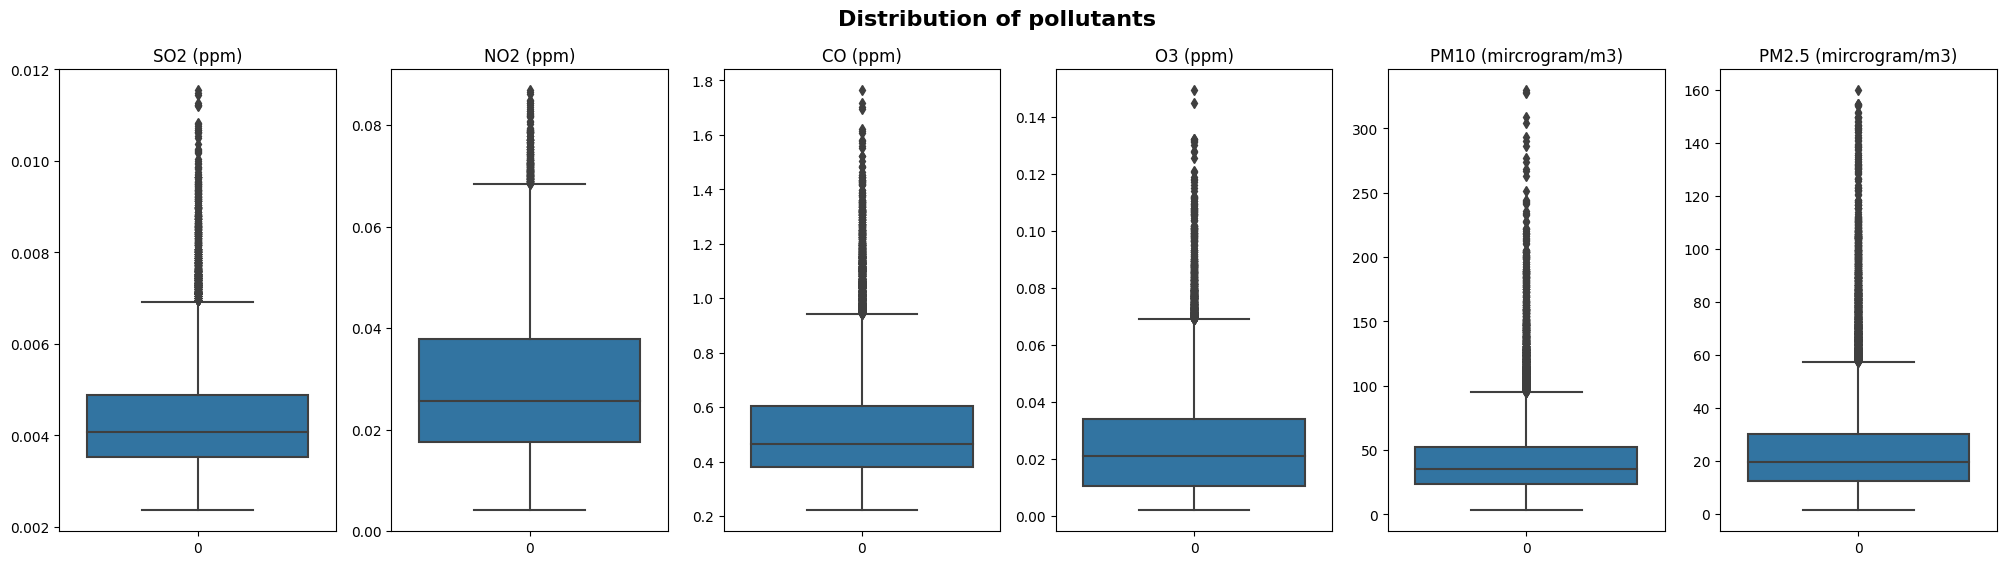

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(25, 6))
fig.suptitle('Distribution of pollutants', fontsize=16, fontweight='bold')
for n, pollutant in enumerate(evaluators.keys()):
    sns.boxplot(data = overview[pollutant], ax=ax[n])
    ax[n].set_title(pollutant)
plt.show()

Theo biểu đồ hộp ở trên, hình dạng của các phân phối gần giống như một cái chuông (bình thường) nhưng hơi lệch về bên phải. Ngoài ra, hãy lưu ý rằng có một số lượng các giá trị ngoại lệ, đặc biệt là trong các phân phối PM10 và PM2.5.

In [ ]:
general = overview.describe().loc[['min', 'max', 'mean', 'std', '25%', '50%', '75%'],:].T
general['level'] = None
for idx, row in general.iterrows():
    general.loc[idx, 'level'] = evaluators[idx](row['mean'])

general.T

SO2 (ppm) NO2 (ppm)  CO (ppm)  O3 (ppm) PM10 (mircrogram/m3)  \
min    0.002364  0.004125  0.220833   0.00188                 3.12   
max    0.011542  0.086875     1.764   0.14944           329.583333   
mean   0.004318  0.028622  0.516274  0.024373            41.573386   
std    0.001092  0.014137  0.197037  0.017895             27.83169   
25%     0.00352   0.01752  0.378261  0.010333            23.583333   
50%     0.00408    0.0256  0.463636  0.021091                 35.5   
75%     0.00488   0.03788     0.604    0.0338            52.275217   
level      Good      Good      Good      Good               Normal   

      PM2.5 (mircrogram/m3)  
min                    1.36  
max                  159.84  
mean              24.011181  
std               17.876667  
25%                   12.24  
50%               19.673333  
75%                   30.32  
level                Normal

Như chúng ta có thể thấy ở trên, mức độ ô nhiễm ở Seoul là tốt. Mặc dù là một trong những thành phố lớn nhất thế giới và có mật độ đô thị hóa dày đặc, nhưng thành phố này có khả năng kiểm soát ô nhiễm rất tốt. Hai điểm có thể cải thiện là nồng độ PM10 và PM2.5, vốn chỉ được coi là bình thường.

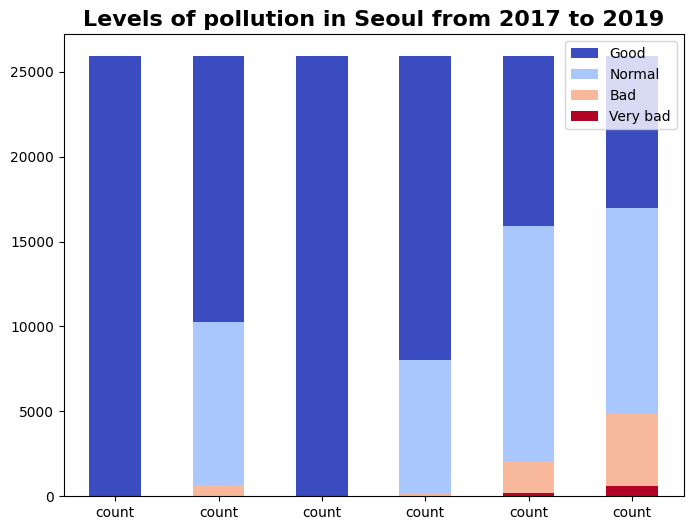

In [ ]:
level_counts = pd.concat([overview[col].value_counts() for col in overview.loc[:, 'SO2 Level':]], axis=1, join='outer', sort=True).fillna(0.0)
level_counts = level_counts.loc[['Very bad', 'Bad', 'Normal', 'Good'], :]

level_counts.T.plot(kind='bar', stacked=True, figsize=(8,6), rot=0,
                    colormap='coolwarm_r', legend='reverse')
plt.title('Levels of pollution in Seoul from 2017 to 2019', fontsize=16, fontweight='bold')
plt.show()

Biểu đồ này hiển thị số lượng của từng mức độ ô nhiễm trong ba năm quan sát. Bên cạnh việc có mức độ ô nhiễm tổng thể tốt, biểu đồ cho thấy đôi khi Seoul vẫn có thể có nồng độ khí và hạt xấu hoặc rất xấu.

### Các chất gây ô nhiễm có tương quan không? <a id='eda-pol-corr'></a>

Chúng ta biết rằng ô tô và các ngành công nghiệp là tác nhân gây ra lượng khí thải ô nhiễm lớn. Ngoài ra, chúng thường thải ra nhiều hơn một loại khí cùng một lúc. Ví dụ, xe cơ giới thường thải ra cả CO ​​và NO2. Vì vậy, chúng ta chấp nhận một số mức độ tương quan giữa các chuỗi thời gian.

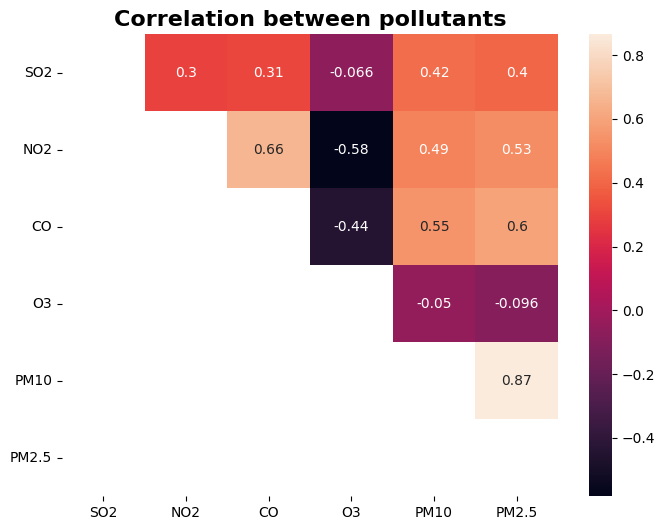

In [ ]:
measures_slice = measures.loc[:, 'SO2 (ppm)':'PM2.5 (mircrogram/m3)']
measures_slice.columns = list(map(lambda x: x.split()[0], measures_slice.columns))
correlations = measures_slice.corr(method='spearman')
mask = np.zeros_like(correlations)
mask[np.tril_indices_from(mask)] = True

plt.figure(figsize=(8,6))
ax = sns.heatmap(data=correlations, annot=True, mask=mask, color=sns.color_palette("coolwarm", 7))
plt.title('Correlation between pollutants', fontsize=16, fontweight='bold')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

Như chúng ta có thể thấy ở trên, hầu hết các tổ hợp biến đều có tương quan tuyệt đối lớn hơn 0,3. Hai tương quan hàng đầu là giữa CO và NO2 và PM10 và PM2,5. Vì vậy, giả thuyết về khí thải xe cộ đã được chứng minh là đúng.

### Nồng độ chất ô nhiễm thay đổi như thế nào theo vị trí?

Để phân tích dữ liệu theo địa lý, trước tiên tính toán nồng độ trung bình của từng chất ô nhiễm theo từng khu vực. Nhưng ở đây chúng ta gặp phải vấn đề là các chất ô nhiễm có các đơn vị đo lường khác nhau. Vì vậy, chuẩn hóa 6 phân phối chất ô nhiễm, mỗi phân phối có 25 điểm (quận).

Trong bản đồ nhiệt sau, thang đo là lượng độ lệch chuẩn so với giá trị trung bình (điểm Z). Các giá trị âm biểu thị mức ô nhiễm dưới mức trung bình và các giá trị dương biểu thị điều ngược lại.

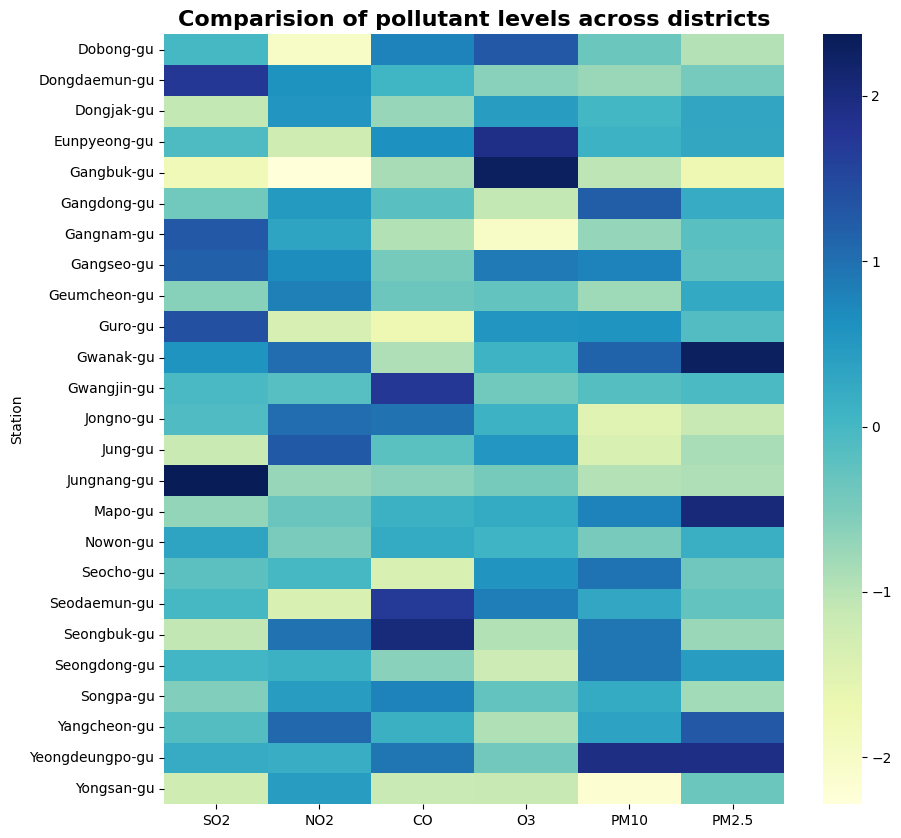

In [ ]:
district_pol = (
    measures
      .groupby('Station')
      .mean(numeric_only=True)            # bỏ tất cả những thứ không phải số xuống dưới mui xe
      .loc[:, 'SO2 (ppm)':'PM2.5 (mircrogram/m3)']
)
district_pol_norm = (district_pol - district_pol.mean()) / district_pol.std()
district_pol_norm.columns = list(map(lambda x: x.split(' ')[0],district_pol_norm.columns))

plt.figure(figsize=(10,10))
sns.heatmap(data=district_pol_norm, cmap="YlGnBu")
plt.title('Comparision of pollutant levels across districts', fontsize=16, fontweight='bold')
plt.xticks(rotation=0)
plt.show()

Trong các bản đồ bên dưới, bạn sẽ thấy sự phân bố địa lý của các chất ô nhiễm. Tất nhiên chúng ta không thể khái quát hóa thông tin thu thập được tại một điểm cụ thể cho toàn bộ khu vực, nhưng đây là một chỉ báo tốt về đặc điểm của quận.

In [ ]:
for col in district_pol_norm.columns:
    pollutant_map = folium.Map(location=[37.562600,127.024612], tiles='cartodbpositron', zoom_start=11)

    # Thêm điểm vào bản đồ
    for idx, row in stations.iterrows():
        Marker([row['Latitude'], row['Longitude']], popup=row['Station name(district)']).add_to(pollutant_map)

    # Thêm choropleth
    Choropleth(
        geo_data=district_borders,
        data=district_pol_norm[col],
        key_on="feature.properties.SIG_ENG_NM",
        fill_color='YlGnBu',
        legend_name='Concentration of {} in Seoul (Z-score)'.format(col)
    ).add_to(pollutant_map)

    display(Markdown('<center><h3>{}</h3></center>'.format(col)))
    display(pollutant_map)

<center><h3>SO2</h3></center>

<center><h3>NO2</h3></center>

<center><h3>O3</h3></center>

<center><h3>PM10</h3></center>

<center><h3>PM2.5</h3></center>

### Những khu vực nào ở Seoul ít ô nhiễm nhất và nhiều nhất?

Để trả lời câu hỏi này, tính điểm Z trung bình của bản đồ nhiệt trước đó và tạo ra một giá trị duy nhất biểu thị mức độ ô nhiễm của từng khu vực. Bản đồ hiển thị các giá trị này có thể được xem bên dưới.

In [ ]:
pollution_map = folium.Map(location=[37.562600,127.024612], tiles='cartodbpositron', zoom_start=11)

# Thêm điểm vào bản đồ
for idx, row in stations.iterrows():
    Marker([row['Latitude'], row['Longitude']], popup=row['Station name(district)']).add_to(pollution_map)

# Thêm choropleth
Choropleth(
    geo_data=district_borders,
    data=district_pol_norm.mean(axis=1),
    key_on="feature.properties.SIG_ENG_NM",
    fill_color='YlGnBu',
    legend_name='Overall pollution in Seoul by region'
).add_to(pollution_map)

pollution_map

### Điều gì thực sự đã xảy ra vào ngày 11 tháng 12?

Đầu tiên, xem nồng độ chất ô nhiễm trung bình của 25 quận. Để làm điều đó, sử dụng DataFrame `overview`.

#### Tổng quan về thành phố

In [ ]:
reported_day_night = pd.Timestamp(year=2019, month=12, day=11, hour=22)

overview.loc[overview.index == reported_day_night, :]

SO2 (ppm)  NO2 (ppm)  CO (ppm)  O3 (ppm)  \
Date                                                            
2019-12-11 22:00:00   0.002957   0.017522  0.378261  0.019739   

                     PM10 (mircrogram/m3)  PM2.5 (mircrogram/m3) SO2 Level  \
Date                                                                         
2019-12-11 22:00:00                  19.0              12.583333      Good   

                    NO2 Level CO Level O3 Level PM10 Level PM2.5 Level  
Date                                                                    
2019-12-11 22:00:00      Good     Good     Good       Good        Good

Như ta thấy đấy, không có gì sai với ô nhiễm vào ngày và giờ được báo cáo trong phần giới thiệu! Nhưng nếu chúng ta xem xét chính xác ngày này nhưng vào lúc 10 giờ sáng, thay vào đó, chúng ta sẽ thấy như sau.

In [ ]:
reported_day_morning = pd.Timestamp(year=2019, month=12, day=11, hour=10)

overview.loc[overview.index == reported_day_morning, :]

SO2 (ppm)  NO2 (ppm)  CO (ppm)  O3 (ppm)  \
Date                                                            
2019-12-11 10:00:00   0.004042     0.0315    0.8625  0.024458   

                     PM10 (mircrogram/m3)  PM2.5 (mircrogram/m3) SO2 Level  \
Date                                                                         
2019-12-11 10:00:00                156.36                 103.96      Good   

                    NO2 Level CO Level O3 Level PM10 Level PM2.5 Level  
Date                                                                    
2019-12-11 10:00:00    Normal     Good     Good   Very bad    Very bad

Vì vậy, có lẽ đã có lỗi đánh máy trong bài viết. Lưu ý rằng, mặc dù nồng độ PM10 và PM2.5 thực sự tệ, nhưng các chất ô nhiễm khác không bị ảnh hưởng.

Nhưng chúng ta vẫn không nhận được cùng một giá trị được báo cáo vì chúng ta đang xem xét mức trung bình của thành phố.

#### Hồ sơ theo trạm

In [ ]:
measures.loc[measures['Date'] == reported_day_morning, :'PM2.5 (mircrogram/m3)'].sort_values('PM2.5 (mircrogram/m3)', ascending=False).head(10)

Date        Station  Status  SO2 (ppm)  NO2 (ppm)  \
667475 2019-12-11 10:00:00    Gangdong-gu  Normal      0.003      0.033   
667464 2019-12-11 10:00:00       Nowon-gu  Normal      0.005      0.036   
667462 2019-12-11 10:00:00     Gangbuk-gu  Normal      0.004      0.032   
667468 2019-12-11 10:00:00   Geumcheon-gu  Normal      0.004      0.034   
667470 2019-12-11 10:00:00     Dongjak-gu  Normal      0.004      0.030   
667450 2019-12-11 10:00:00      Jongno-gu  Normal      0.005      0.036   
667459 2019-12-11 10:00:00  Dongdaemun-gu  Normal      0.004      0.032   
667452 2019-12-11 10:00:00     Yongsan-gu  Normal      0.004      0.029   
667451 2019-12-11 10:00:00        Jung-gu  Normal      0.004      0.032   
667456 2019-12-11 10:00:00        Mapo-gu  Normal      0.005      0.037   

        CO (ppm)  O3 (ppm)  PM10 (mircrogram/m3)  PM2.5 (mircrogram/m3)  
667475       0.9     0.022                 192.0                  152.0  
667464       0.9     0.025                 154.0                  133.0  
667462       0.8     0.038                 186.0                  128.0  
667468       0.8     0.019                 150.0                  127.0  
667470       0.8     0.020                 175.0                  125.0  
667450       1.0     0.016                 156.0                  116.0  
667459       0.9     0.022                 166.0                  113.0  
667452       0.9     0.025                 151.0                  110.0  
667451       0.9     0.024                 151.0                  108.0  
667456       0.9     0.021                 143.0                  107.0

Trong bảng trên, đã hiển thị 10 hàng đầu tiên của hồ sơ ô nhiễm trong giờ chính xác và được sắp xếp theo giá trị PM2.5. Không thể thấy giá trị được báo cáo là 118 microgam/m3, nhưng điều này có thể xảy ra vì ta đang thấy giá trị trung bình của một giờ.

#### So sánh với toàn bộ tháng

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

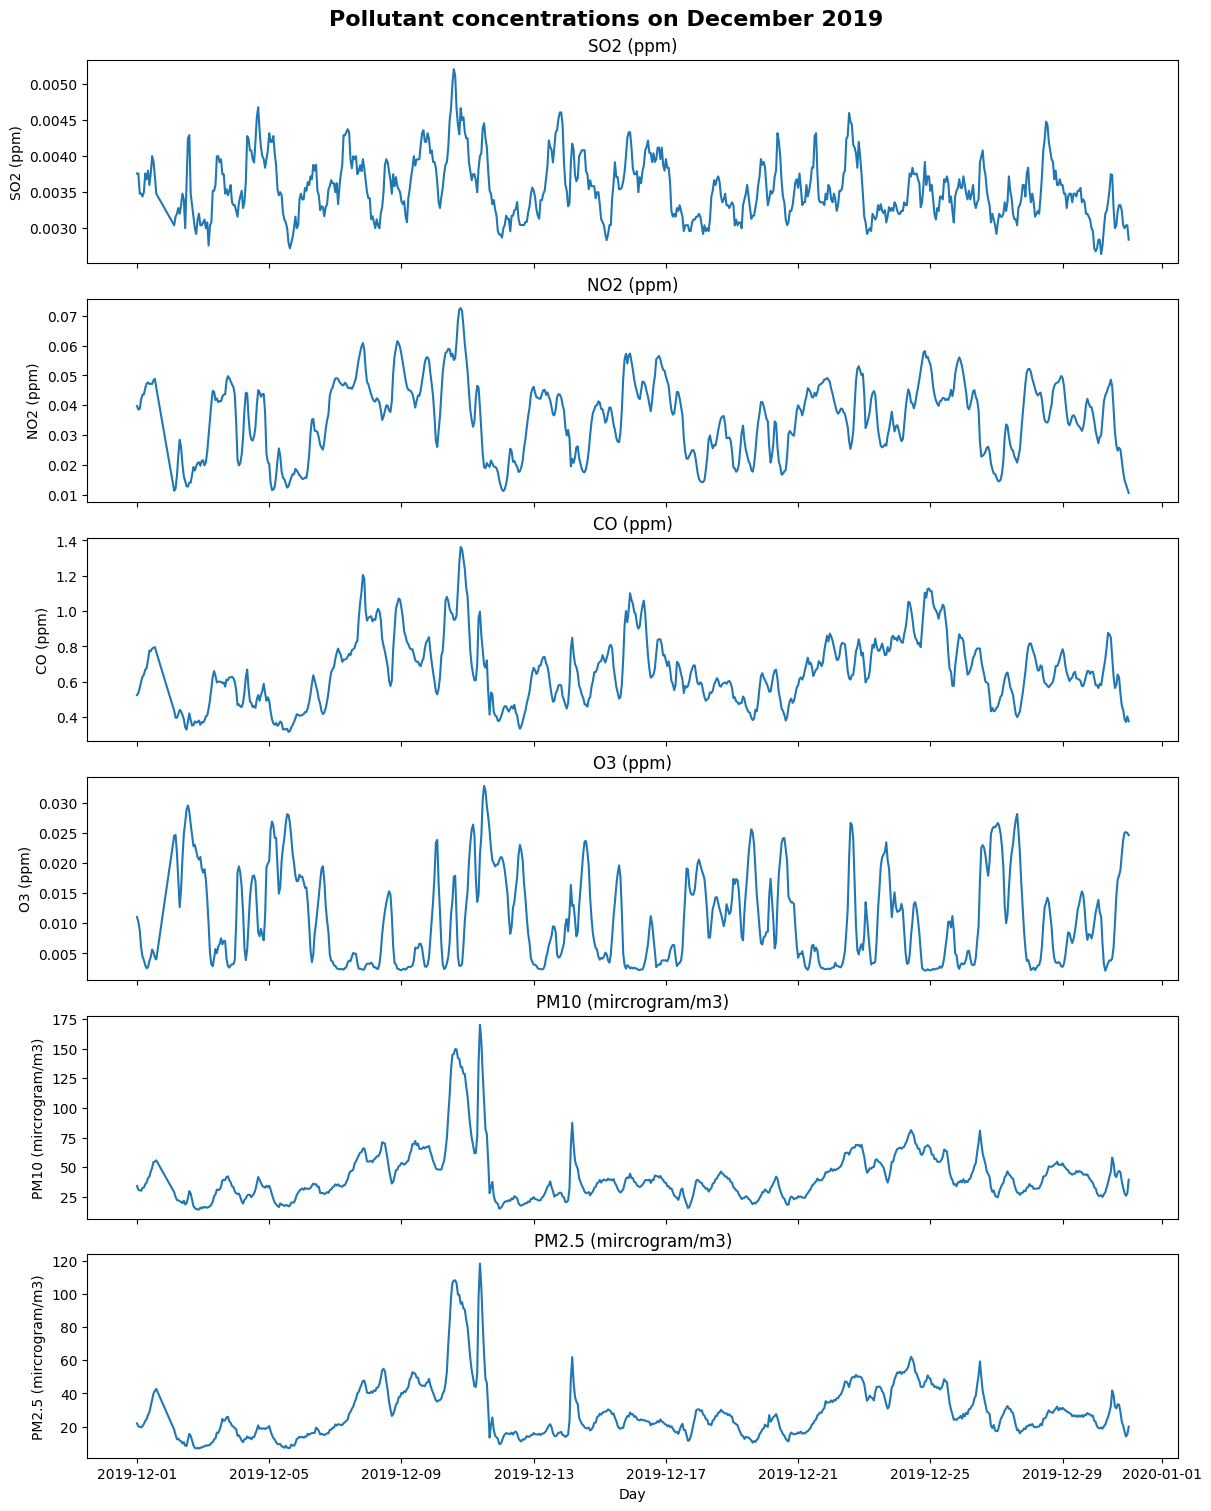

In [ ]:
first_day_dec = pd.Timestamp(year=2019, month=12, day=1)
last_day_dec = pd.Timestamp(year=2019, month=12, day=31)

december = overview.loc[(overview.index >= first_day_dec) & (overview.index <= last_day_dec),:]

fig, ax = plt.subplots(6, 1, figsize=(12, 15), sharex=True, constrained_layout=True)
fig.suptitle('Pollutant concentrations on December 2019', fontsize=16, fontweight='bold')
for n, pollutant in enumerate(evaluators.keys()):
    sns.lineplot(data = december[pollutant], ax=ax[n])
    ax[n].set_title(pollutant)
plt.xlabel('Day')
plt.show()

Chúng ta có thể thấy rằng tất cả các chất gây ô nhiễm, ngoại trừ O3, đều có sự gia tăng đột biến vào giữa tháng. Nhưng sự gia tăng đột biến này rõ ràng hơn nhiều trong hai chuỗi thời gian gần đây nhất.

### Nồng độ chất ô nhiễm có tính chất và xu hướng không? (sẽ được mở rộng)

Để phân tích điều này, trước tiên chúng ta lấy giá trị trung bình của nồng độ mỗi giờ và chất ô nhiễm.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

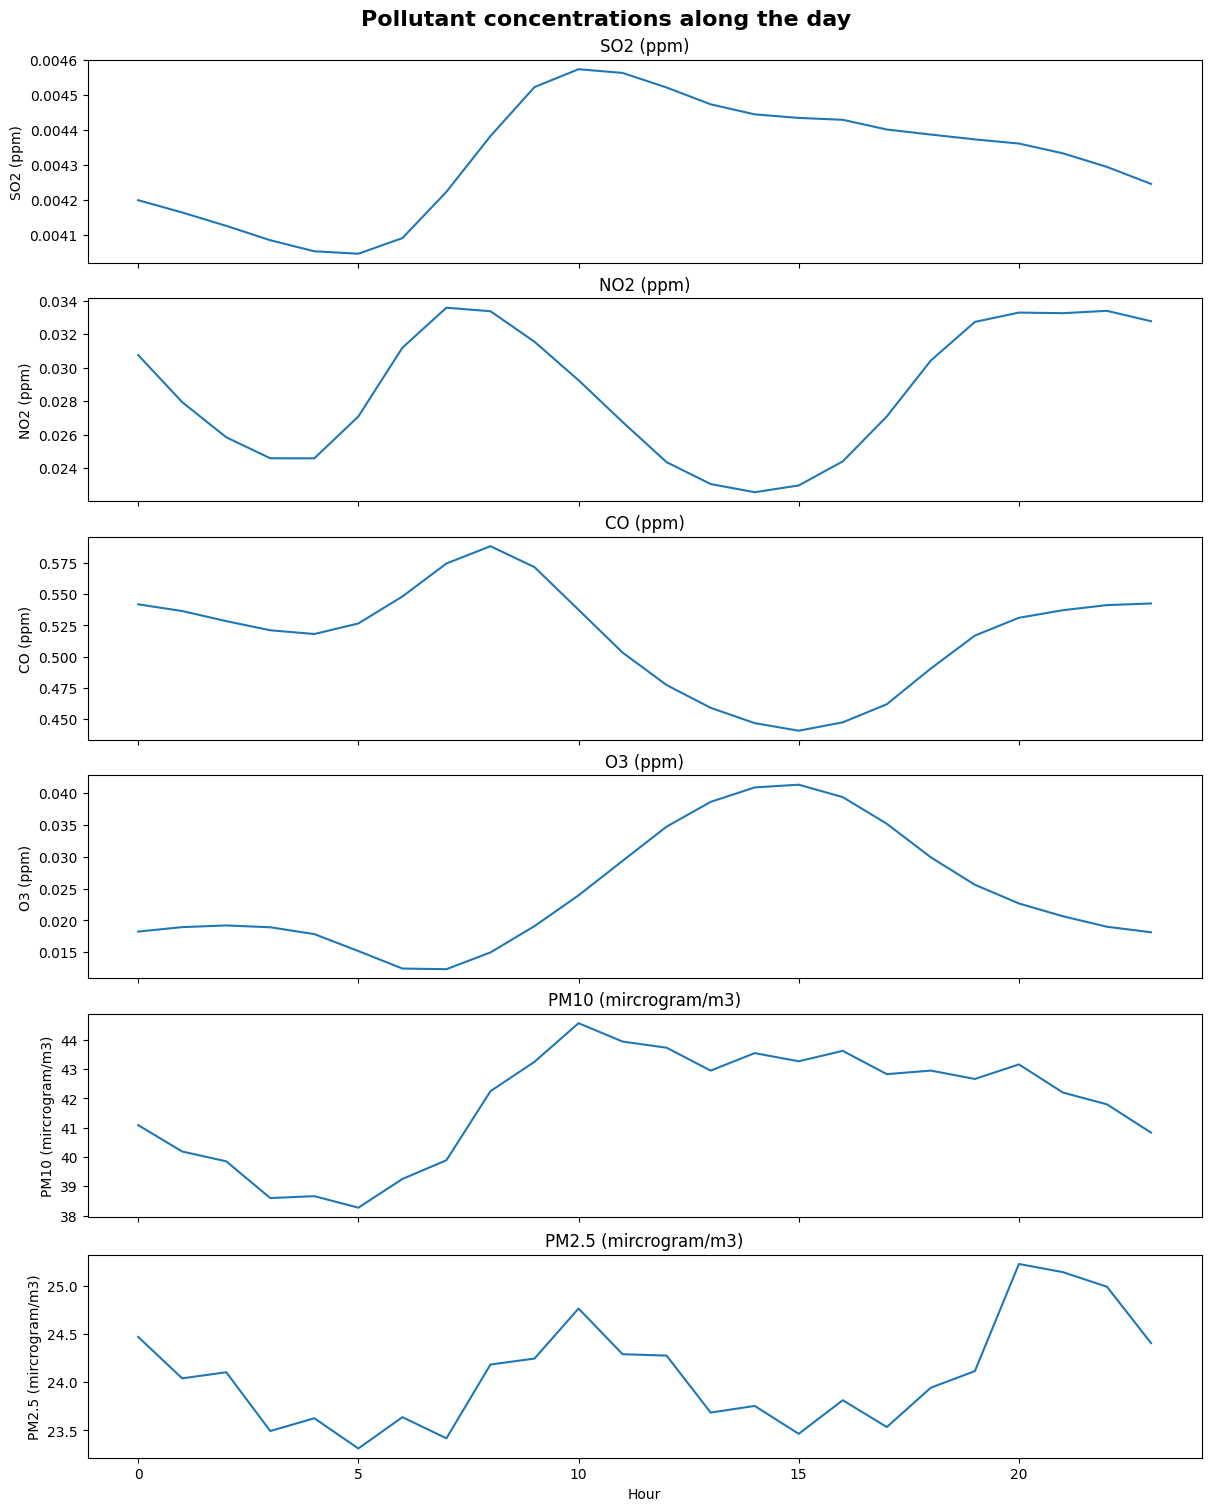

In [ ]:
concentration_hour = (
    measures
      .groupby('Hour')
      .mean(numeric_only=True)
)

fig, ax = plt.subplots(6, 1, figsize=(12, 15), sharex=True, constrained_layout=True)
fig.suptitle('Pollutant concentrations along the day', fontsize=16, fontweight='bold')
for n, pollutant in enumerate(evaluators.keys()):
    sns.lineplot(data = concentration_hour[pollutant], ax=ax[n])
    ax[n].set_title(pollutant)
plt.xlabel('Hour')
plt.show()


Chắc chắn, mỗi chất ô nhiễm có hành vi khác nhau. Một số có hai đỉnh mỗi ngày và một số chỉ có một. Nhưng một điểm chung là tất cả chúng đều có một thung lũng vào buổi sáng. Ngoài ra, các chất ô nhiễm được đo bằng ppm có đường cong mượt mà hơn so với các chất được đo bằng ug/m3.

Trong biểu đồ tiếp theo, chúng ta sẽ xem liệu có sazonality và xu hướng trong chuỗi thời gian của chất ô nhiễm hay không.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

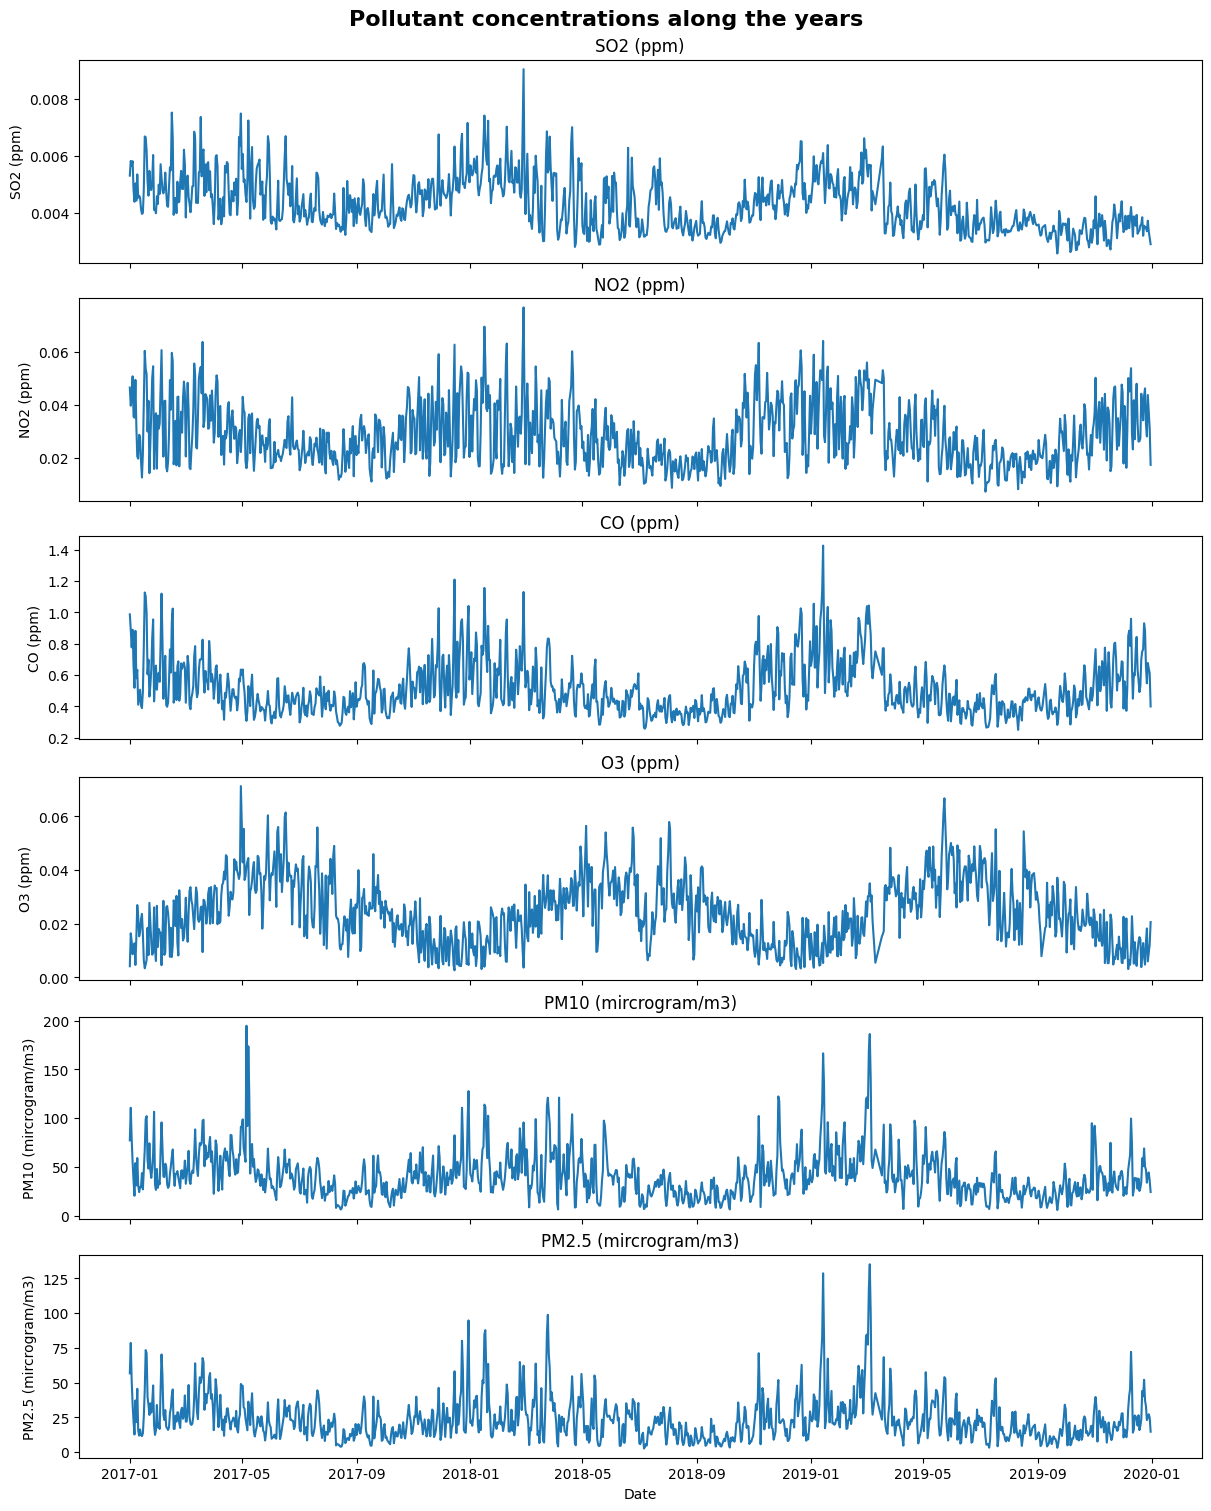

In [ ]:
measures_slice = measures.loc[:, ['Date'] + list(evaluators.keys())]
measures_slice['Date'] = measures['Date'].dt.date
concentrations_day = measures_slice.groupby('Date').mean()

fig, ax = plt.subplots(6, 1, figsize=(12, 15), sharex=True, constrained_layout=True)
fig.suptitle('Pollutant concentrations along the years', fontsize=16, fontweight='bold')
for n, pollutant in enumerate(evaluators.keys()):
    sns.lineplot(data = concentrations_day[pollutant], ax=ax[n])
    ax[n].set_title(pollutant)
plt.xlabel('Date')
plt.show()


### Điều gì xảy ra khi một công cụ không hoạt động bình thường?

#### Mẫu ngẫu nhiên các hàng có vấn đề

In [ ]:
bad_measures.loc[:, 'Status':'PM2.5 (mircrogram/m3)'].sample(10, random_state=42)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Status  SO2 (ppm)  NO2 (ppm)  CO (ppm)  O3 (ppm)  \
625728         Power cut off     -1.000     -1.000      -1.0    -1.000   
339888         Abnormal data        NaN        NaN       NaN       NaN   
115447         Abnormal data        NaN        NaN       NaN       NaN   
605564         Power cut off     -1.000     -1.000      -1.0    -1.000   
417962  Need for calibration      0.081      0.015       3.1     0.005   
586470         Abnormal data        NaN        NaN       NaN       NaN   
623705         Power cut off     -1.000     -1.000      -1.0    -1.000   
462382  Need for calibration      0.000      0.000       0.0     0.000   
187254  Need for calibration      0.000      0.000       0.0     0.000   
616000         Abnormal data        NaN        NaN       NaN       NaN   

        PM10 (mircrogram/m3)  PM2.5 (mircrogram/m3)  
625728                  -1.0                   -1.0  
339888                  64.0                    NaN  
115447                  50.0                    NaN  
605564                  -1.0                   -1.0  
417962                  21.0                   36.0  
586470                   NaN                  985.0  
623705                  -1.0                   -1.0  
462382                   4.0                    0.0  
187254                   0.0                    NaN  
616000                   NaN                   16.0

#### Các hàng mà phép đo cần phải bị loại bỏ nhưng đã được thu thập

In [ ]:
bad_measures.loc[
    ~bad_measures.loc[:, 'SO2 (ppm)':'PM2.5 (mircrogram/m3)']
                 .isnull()
                 .any(axis=1),
    'Status':'PM2.5 (mircrogram/m3)'
]

Status  SO2 (ppm)  NO2 (ppm)  CO (ppm)  O3 (ppm)  \
602            Power cut off     -1.000     -1.000      -1.0    -1.000   
822            Power cut off      0.000      0.000       0.0     0.000   
847             Under repair      0.007      0.049       0.3     0.007   
956     Need for calibration      0.006      0.037       0.7     0.023   
981     Need for calibration      0.000      0.000       0.0     0.000   
...                      ...        ...        ...       ...       ...   
677558  Need for calibration      0.003      0.019       0.3     0.020   
679243  Need for calibration      0.041      0.027       5.5     0.020   
679269  Need for calibration      0.059      0.036       5.7     0.002   
679833  Need for calibration      0.003      0.013       0.3     0.028   
679860  Need for calibration      0.003      0.008       0.3     0.026   

        PM10 (mircrogram/m3)  PM2.5 (mircrogram/m3)  
602                     -1.0                   -1.0  
822                      0.0                    0.0  
847                     49.0                   30.0  
956                     62.0                   42.0  
981                      0.0                    0.0  
...                      ...                    ...  
677558                  18.0                   14.0  
679243                 176.0                  167.0  
679269                  82.0                   75.0  
679833                  19.0                   10.0  
679860                  17.0                    7.0  

[10145 rows x 7 columns]

Lưu ý rằng khi trạng thái của thiết bị khác với trạng thái bình thường, nó vẫn có thể cung cấp các phép đo có vẻ đúng. Nhưng nó cũng có thể đưa ra các số bất thường hoặc âm. Vì chúng ta không biết các thiết bị này hoạt động như thế nào và liệu chúng có thể cung cấp các phép đo đáng tin cậy ngay cả khi cần hiệu chuẩn hay không, thì việc loại bỏ các hàng này sẽ an toàn hơn.

### Có bao nhiêu lần một thiết bị có trạng thái khác với trạng thái bình thường? <a id='eda-inst-dif-status'><a/>

Percentage of abnormal measurements: 6.31837394788106


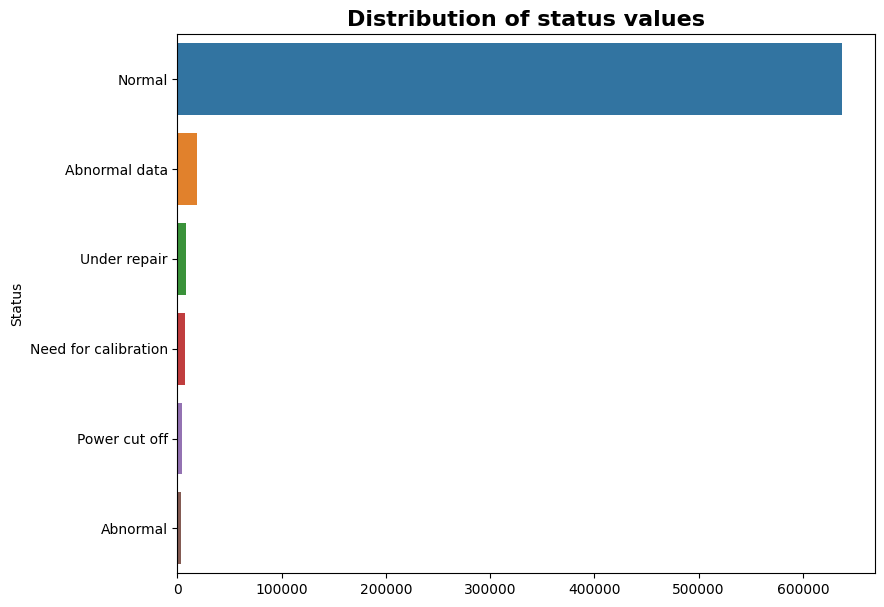

In [ ]:
print('Percentage of abnormal measurements:', bad_measures.shape[0] * 100 / all_measures.shape[0])

counts = all_measures['Status'].value_counts()
plt.figure(figsize=(9,7))
plt.title('Distribution of status values', fontsize=16, fontweight='bold')
sns.barplot(x = counts.values, y = counts.index)
plt.show()

### Có một mô hình nào đó về thời điểm một thiết bị ngừng hoạt động không? <a id='eda-inst-when'><a/>

Để trả lời câu hỏi này, nhóm các hàng bất thường theo giờ trong ngày.

/tmp/ipykernel_35/3475833939.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bad_hourly = bad_measures.groupby('Hour').apply(len)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


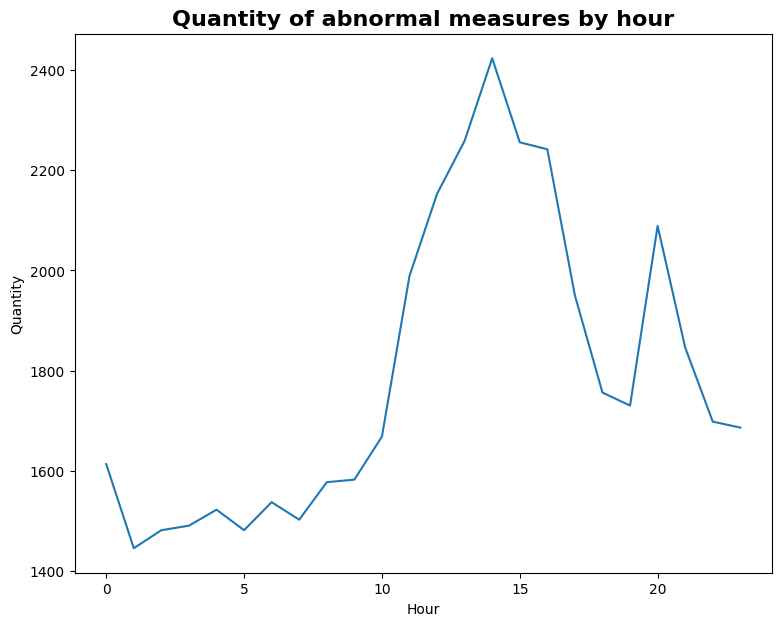

In [ ]:
# Fails by time
#bad_measures.groupby('Year').apply(len)
#bad_measures.groupby('Month').apply(len)
bad_hourly = bad_measures.groupby('Hour').apply(len)

plt.figure(figsize=(9,7))
plt.ylabel('Quantity')
plt.xlabel('Hour')
plt.title('Quantity of abnormal measures by hour', fontsize=16, fontweight='bold')
sns.lineplot(data=bad_hourly)
plt.show()

/tmp/ipykernel_35/4067349763.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bad_measures_hour = bad_measures.groupby(['Hour', 'Status']).apply(len).rename('Quantity').reset_index().pivot(index='Hour', columns='Status', values='Quantity').fillna(0).astype('int64')


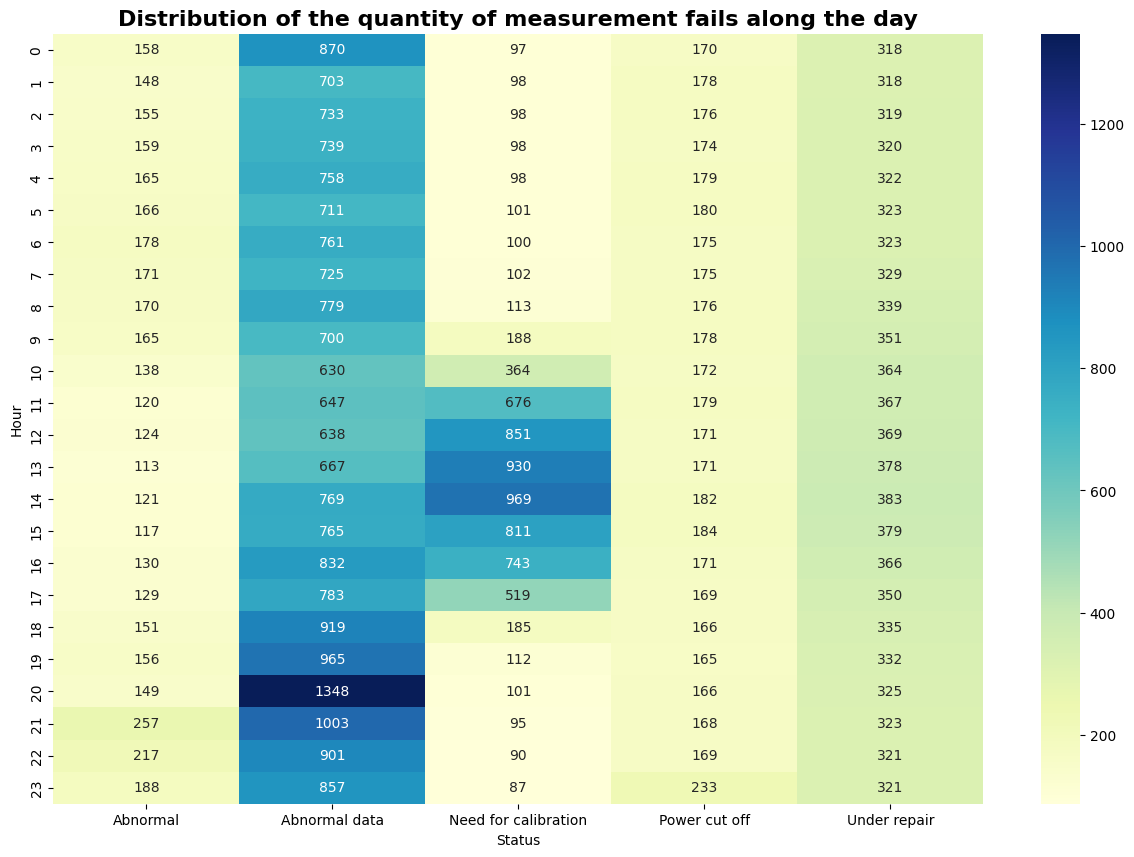

In [ ]:
bad_measures_hour = bad_measures.groupby(['Hour', 'Status']).apply(len).rename('Quantity').reset_index().pivot(index='Hour', columns='Status', values='Quantity').fillna(0).astype('int64')

plt.figure(figsize=(15,10))
plt.title('Distribution of the quantity of measurement fails along the day', fontsize=16, fontweight='bold')
sns.heatmap(data=bad_measures_hour, cmap="YlGnBu", annot=True, fmt='d')
plt.show()

Chúng ta có thể nhận thấy một vài điều theo hai sơ đồ cuối cùng:

- Một thiết bị có thể được sửa chữa vào bất kỳ thời điểm nào trong ngày. Tuy nhiên, khả năng sửa chữa vào buổi sáng hoặc buổi tối cao hơn một chút.
- Sự cố về nguồn điện có thể xảy ra hầu như bất kỳ lúc nào.
- Có nhiều khả năng cần hiệu chuẩn vào đầu buổi tối.
- Dữ liệu bất thường được tạo ra thường xuyên hơn vào đầu buổi chiều, khoảng 8 giờ tối.
- Phân tích sự phân bố của "cần hiệu chuẩn" và "dữ liệu bất thường" kết hợp, có thể suy ra rằng khi một thiết bị bắt đầu hoạt động bất ngờ, trước tiên nó sẽ thay đổi trạng thái thành "cần hiệu chuẩn". Sau một thời gian, nó lại thay đổi trạng thái thành "dữ liệu bất thường", vì việc thiếu hiệu chuẩn sẽ khiến thiết bị đưa ra các số lạ hoặc thậm chí không đưa ra chúng.

### Có khu vực nào có nhiều sự cố về thiết bị hơn không? <a id='eda-inst-where'><a/>

Trong bối cảnh này, nhóm các vấn đề theo quận.

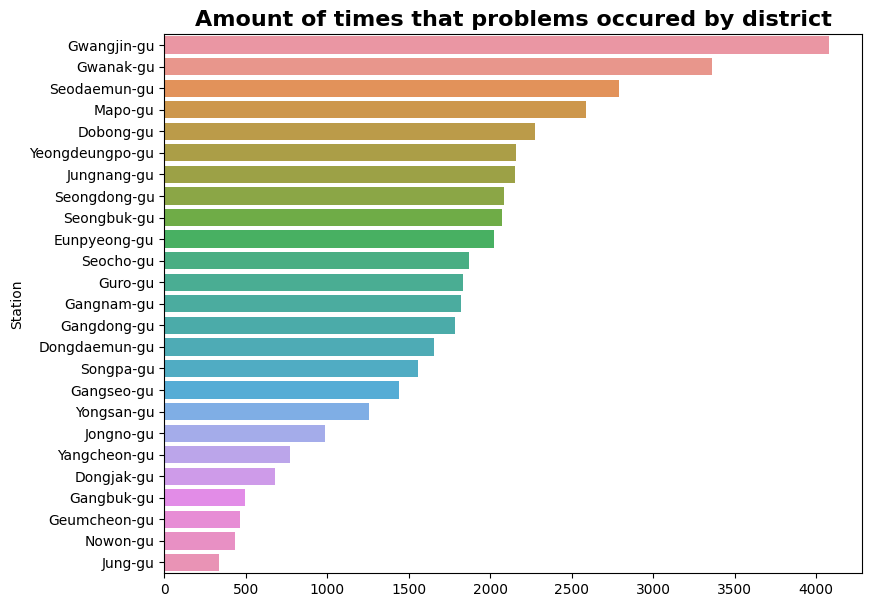

In [ ]:
# Thất bại theo trạm
bad_stations = bad_measures['Station'].value_counts()

plt.figure(figsize=(9,7))
plt.title('Amount of times that problems occured by district', fontsize=16, fontweight='bold')
sns.barplot(x = bad_stations.values, y = bad_stations.index)
plt.show()

/tmp/ipykernel_35/1979737933.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bad_measures_station = bad_measures.groupby(['Station', 'Status']).apply(len).rename('Quantity').reset_index().pivot(index='Station', columns='Status', values='Quantity').fillna(0).astype('int64')


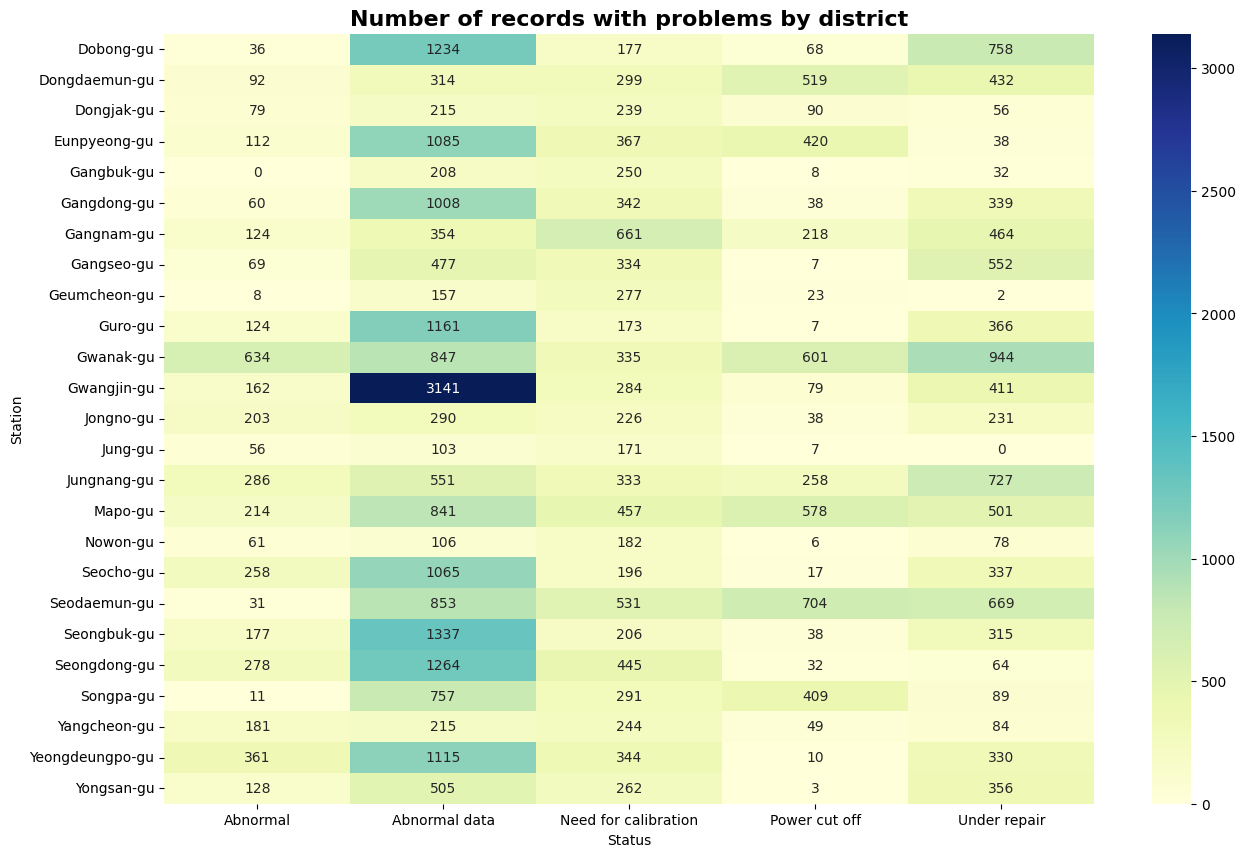

In [ ]:
bad_measures_station = bad_measures.groupby(['Station', 'Status']).apply(len).rename('Quantity').reset_index().pivot(index='Station', columns='Status', values='Quantity').fillna(0).astype('int64')

plt.figure(figsize=(15,10))
sns.heatmap(data=bad_measures_station, cmap="YlGnBu", annot=True, fmt='d')
plt.title('Number of records with problems by district', fontsize=16, fontweight='bold')
plt.show()

Chúng ta có thể thấy rằng một số quận có số lượng lớn tình trạng xấu, ví dụ như Gwangjin-gu, Gwanak-gu và Seodaemun-gu. Mặc dù không biết điều gì thực sự đã xảy ra với các thiết bị này, đề xuất thay thế để xem chúng có ít vấn đề hơn không. Thiết bị ở Gwanak-gu có lẽ đã cũ, vì nó có số lượng trạng thái "đang sửa chữa" cao nhất.

# Xây dựng mô hình dự đoán

In [ ]:
Seoul = measures.copy()

Seoul = Seoul[["Date" , "PM2.5 (mircrogram/m3)" , "PM10 (mircrogram/m3)" , "O3 (ppm)" , "NO2 (ppm)" , "SO2 (ppm)" , "CO (ppm)"]]
Seoul["Date"] = pd.to_datetime(Seoul["Date"])
Seoul

Date  PM2.5 (mircrogram/m3)  PM10 (mircrogram/m3)  \
0      2017-01-01 00:00:00                   57.0                  73.0   
1      2017-01-01 00:00:00                   63.0                  77.0   
2      2017-01-01 00:00:00                   68.0                  70.0   
3      2017-01-01 00:00:00                   46.0                  73.0   
4      2017-01-01 00:00:00                   44.0                  81.0   
...                    ...                    ...                   ...   
680170 2019-12-31 23:00:00                   16.0                  29.0   
680171 2019-12-31 23:00:00                   15.0                  24.0   
680172 2019-12-31 23:00:00                   13.0                  19.0   
680173 2019-12-31 23:00:00                   13.0                  20.0   
680174 2019-12-31 23:00:00                   18.0                  27.0   

        O3 (ppm)  NO2 (ppm)  SO2 (ppm)  CO (ppm)  
0          0.002      0.059      0.004       1.2  
1          0.002      0.068      0.006       1.3  
2          0.002      0.039      0.005       1.4  
3          0.003      0.045      0.005       0.6  
4          0.004      0.044      0.005       1.0  
...          ...        ...        ...       ...  
680170     0.013      0.042      0.003       0.5  
680171     0.007      0.047      0.003       0.4  
680172     0.003      0.039      0.003       0.5  
680173     0.004      0.035      0.003       0.5  
680174     0.005      0.037      0.003       0.5  

[637199 rows x 7 columns]

In [ ]:
df2 = (
    Seoul.set_index("Date")
      .resample("D")       # daily bins
      .mean()              # trung bình của mỗi chất ô nhiễm mỗi ngày
      .reset_index()
)
# mask = (df2['Date'] >= '2019-01-01') & (df2['Date'] <= '2019-12-31')
# df2 = df2.loc[mask].copy().reset_index(drop = True)
df2

Date  PM2.5 (mircrogram/m3)  PM10 (mircrogram/m3)  O3 (ppm)  \
0    2017-01-01              56.783784             77.332220  0.004152   
1    2017-01-02              78.614334            110.657534  0.016427   
2    2017-01-03              51.504244             78.603390  0.013375   
3    2017-01-04              34.362862             54.884550  0.008625   
4    2017-01-05              22.218644             35.846939  0.011389   
...         ...                    ...                   ...       ...   
1090 2019-12-27              23.069492             33.991525  0.018232   
1091 2019-12-28              25.313333             42.831667  0.005945   
1092 2019-12-29              27.306667             44.454090  0.008980   
1093 2019-12-30              24.885714             35.906780  0.012370   
1094 2019-12-31              14.757627             24.451724  0.020620   

      NO2 (ppm)  SO2 (ppm)  CO (ppm)  
0      0.046509   0.005302  0.987817  
1      0.039706   0.005823  0.889384  
2      0.042633   0.005658  0.777055  
3      0.050699   0.005812  0.889679  
4      0.035638   0.004796  0.657647  
...         ...        ...       ...  
1090   0.028187   0.003338  0.547395  
1091   0.043712   0.003710  0.677167  
1092   0.037145   0.003337  0.641333  
1093   0.031203   0.003116  0.611893  
1094   0.017555   0.002880  0.399666  

[1095 rows x 7 columns]

In [ ]:
df2 = df2.interpolate(method='linear', limit_direction='both')

df2 = df2.reset_index(drop = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   1095 non-null   datetime64[ns]
 1   PM2.5 (mircrogram/m3)  1095 non-null   float64       
 2   PM10 (mircrogram/m3)   1095 non-null   float64       
 3   O3 (ppm)               1095 non-null   float64       
 4   NO2 (ppm)              1095 non-null   float64       
 5   SO2 (ppm)              1095 non-null   float64       
 6   CO (ppm)               1095 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 60.0 KB


<Figure size 1000x1200 with 0 Axes>

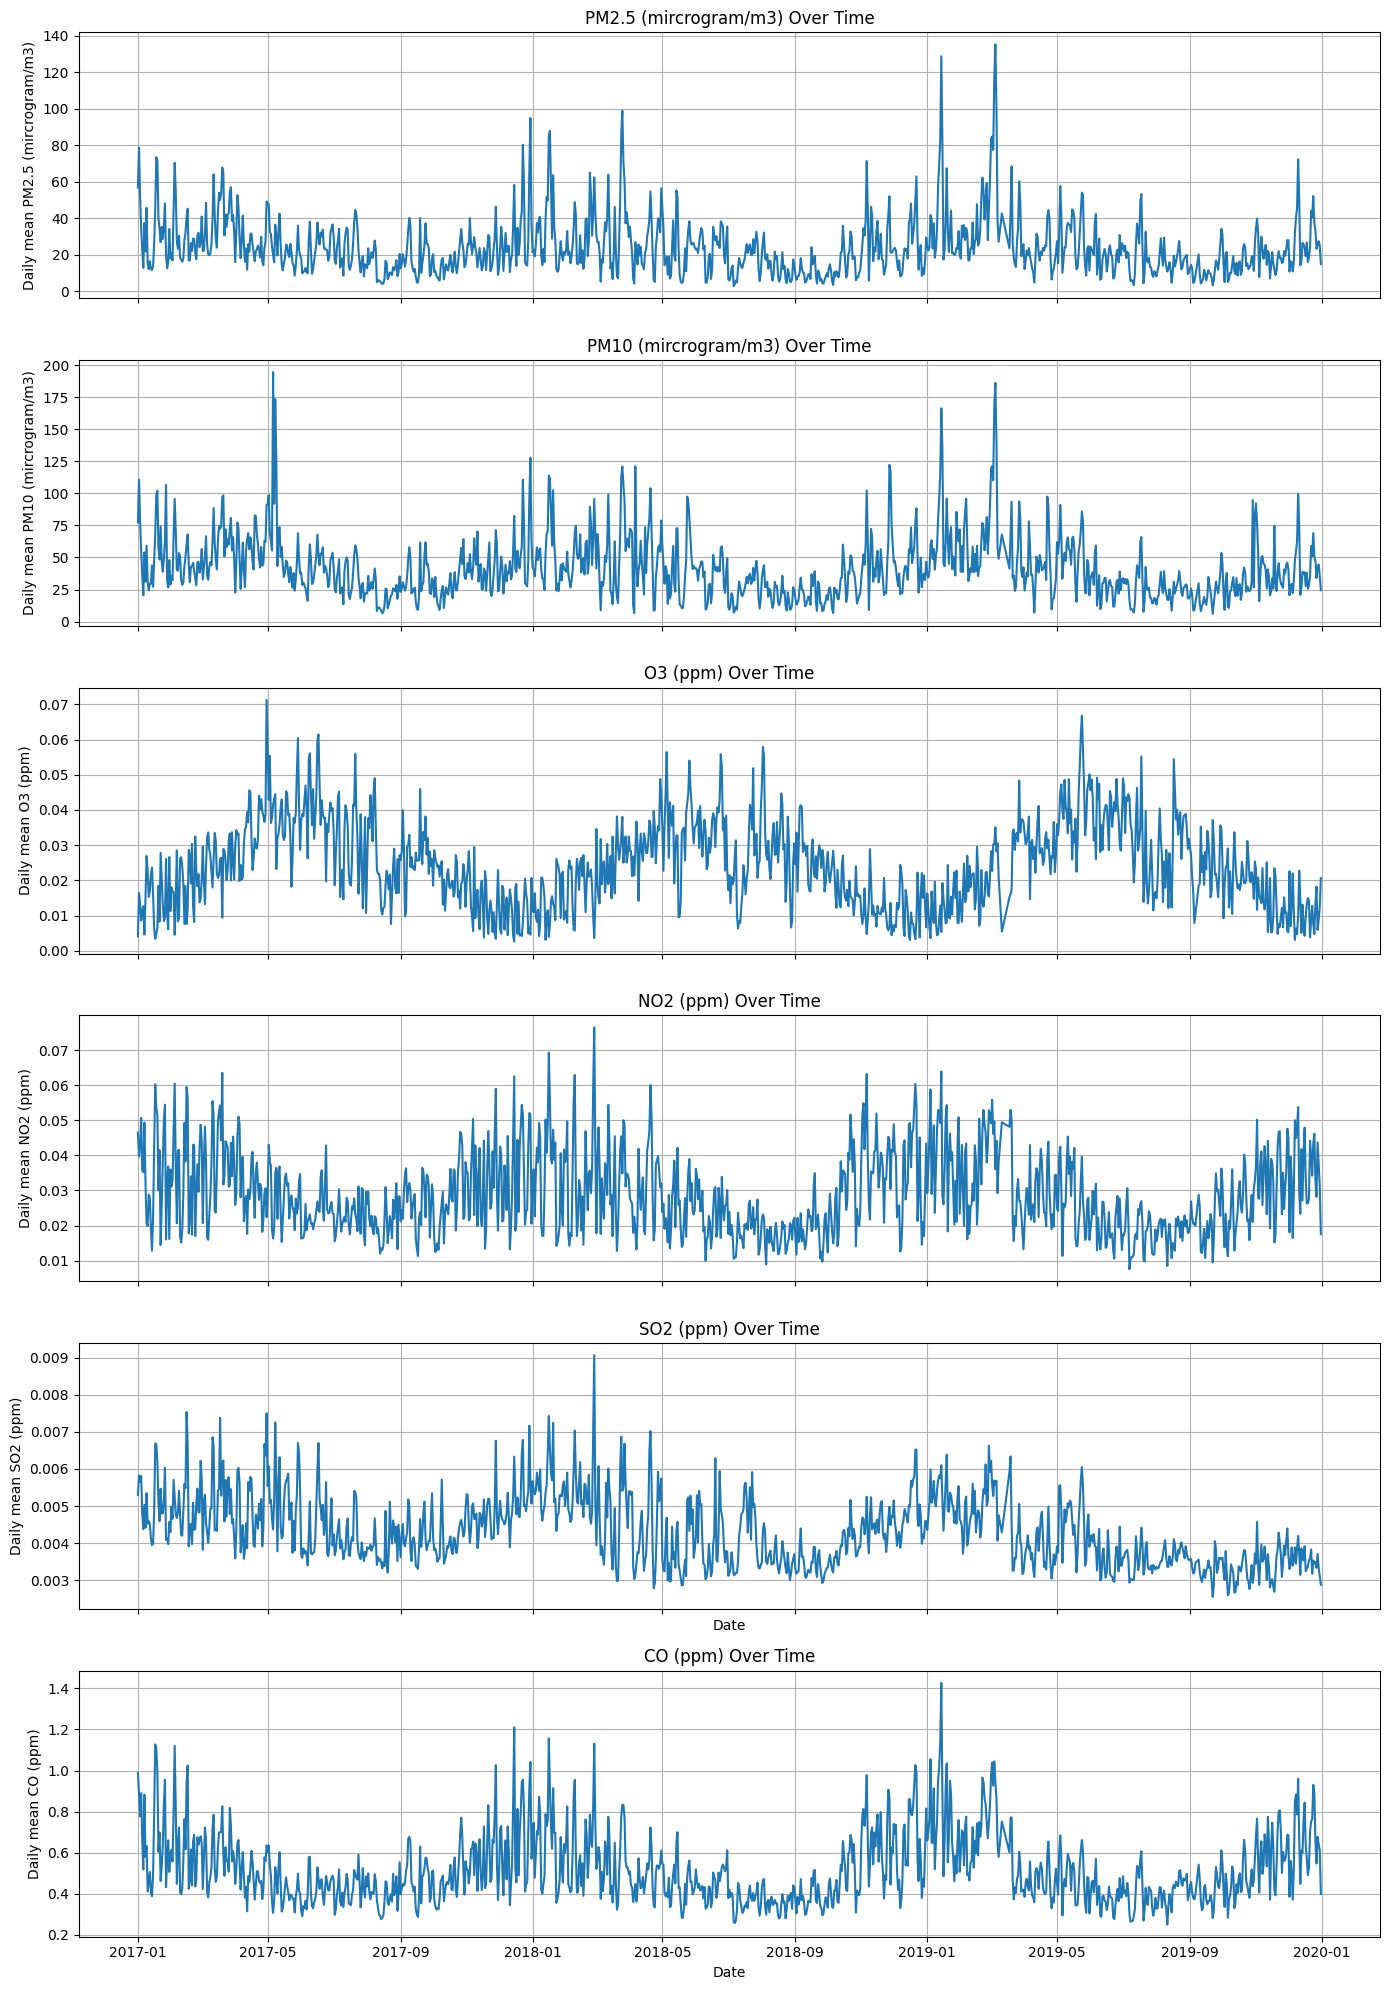

In [ ]:
# Chuẩn bị index
fig = plt.figure(figsize =(10, 12))
df2['Date'] = pd.to_datetime(df2['Date'])
df2.set_index('Date', inplace=True)
df2.sort_index(inplace=True)

pollutants = ["PM2.5 (mircrogram/m3)" , "PM10 (mircrogram/m3)" , "O3 (ppm)" , "NO2 (ppm)" , "SO2 (ppm)" , "CO (ppm)"]

# Lưới 3×2 của chuỗi thời gian
fig, axes = plt.subplots(6, 1, figsize=(14,20), sharex=True)
axes = axes.ravel()

for i, col in enumerate(pollutants):
    axes[i].plot(df2.index, df2[col])
    axes[i].set_title(f"{col} Over Time")
    axes[i].set_ylabel(f"Daily mean {col}")
    if i >= 4:  # only bottom row gets x‐label
        axes[i].set_xlabel("Date")
    axes[i].grid(True)

fig.tight_layout()
plt.show()

In [ ]:
df2

PM2.5 (mircrogram/m3)  PM10 (mircrogram/m3)  O3 (ppm)  NO2 (ppm)  \
Date                                                                           
2017-01-01              56.783784             77.332220  0.004152   0.046509   
2017-01-02              78.614334            110.657534  0.016427   0.039706   
2017-01-03              51.504244             78.603390  0.013375   0.042633   
2017-01-04              34.362862             54.884550  0.008625   0.050699   
2017-01-05              22.218644             35.846939  0.011389   0.035638   
...                           ...                   ...       ...        ...   
2019-12-27              23.069492             33.991525  0.018232   0.028187   
2019-12-28              25.313333             42.831667  0.005945   0.043712   
2019-12-29              27.306667             44.454090  0.008980   0.037145   
2019-12-30              24.885714             35.906780  0.012370   0.031203   
2019-12-31              14.757627             24.451724  0.020620   0.017555   

            SO2 (ppm)  CO (ppm)  
Date                             
2017-01-01   0.005302  0.987817  
2017-01-02   0.005823  0.889384  
2017-01-03   0.005658  0.777055  
2017-01-04   0.005812  0.889679  
2017-01-05   0.004796  0.657647  
...               ...       ...  
2019-12-27   0.003338  0.547395  
2019-12-28   0.003710  0.677167  
2019-12-29   0.003337  0.641333  
2019-12-30   0.003116  0.611893  
2019-12-31   0.002880  0.399666  

[1095 rows x 6 columns]

### Chuẩn hóa dữ liệu sang miền (0,1]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# instantiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# select numeric columns
num_cols = df2.select_dtypes(include=['number']).columns

# fit on the data and transform
df2[num_cols] = scaler.fit_transform(df2[num_cols])
df2

PM2.5 (mircrogram/m3)  PM10 (mircrogram/m3)  O3 (ppm)  NO2 (ppm)  \
Date                                                                           
2017-01-01               0.408268              0.378141  0.022167   0.565196   
2017-01-02               0.572920              0.554834  0.200931   0.466589   
2017-01-03               0.368448              0.384881  0.156477   0.509017   
2017-01-04               0.239163              0.259121  0.087312   0.625924   
2017-01-05               0.147568              0.158182  0.127555   0.407634   
...                           ...                   ...       ...        ...   
2019-12-27               0.153985              0.148345  0.227214   0.299632   
2019-12-28               0.170909              0.195216  0.048280   0.524649   
2019-12-29               0.185943              0.203818  0.092479   0.429474   
2019-12-30               0.167683              0.158500  0.141850   0.343347   
2019-12-31               0.091295              0.097764  0.261998   0.145544   

            SO2 (ppm)  CO (ppm)  
Date                             
2017-01-01   0.422342  0.626897  
2017-01-02   0.502409  0.543261  
2017-01-03   0.476941  0.447819  
2017-01-04   0.500618  0.543512  
2017-01-05   0.344642  0.346363  
...               ...       ...  
2019-12-27   0.120608  0.252686  
2019-12-28   0.177777  0.362948  
2019-12-29   0.120431  0.332502  
2019-12-30   0.086471  0.307487  
2019-12-31   0.050224  0.127165  

[1095 rows x 6 columns]

<Figure size 1000x1200 with 0 Axes>

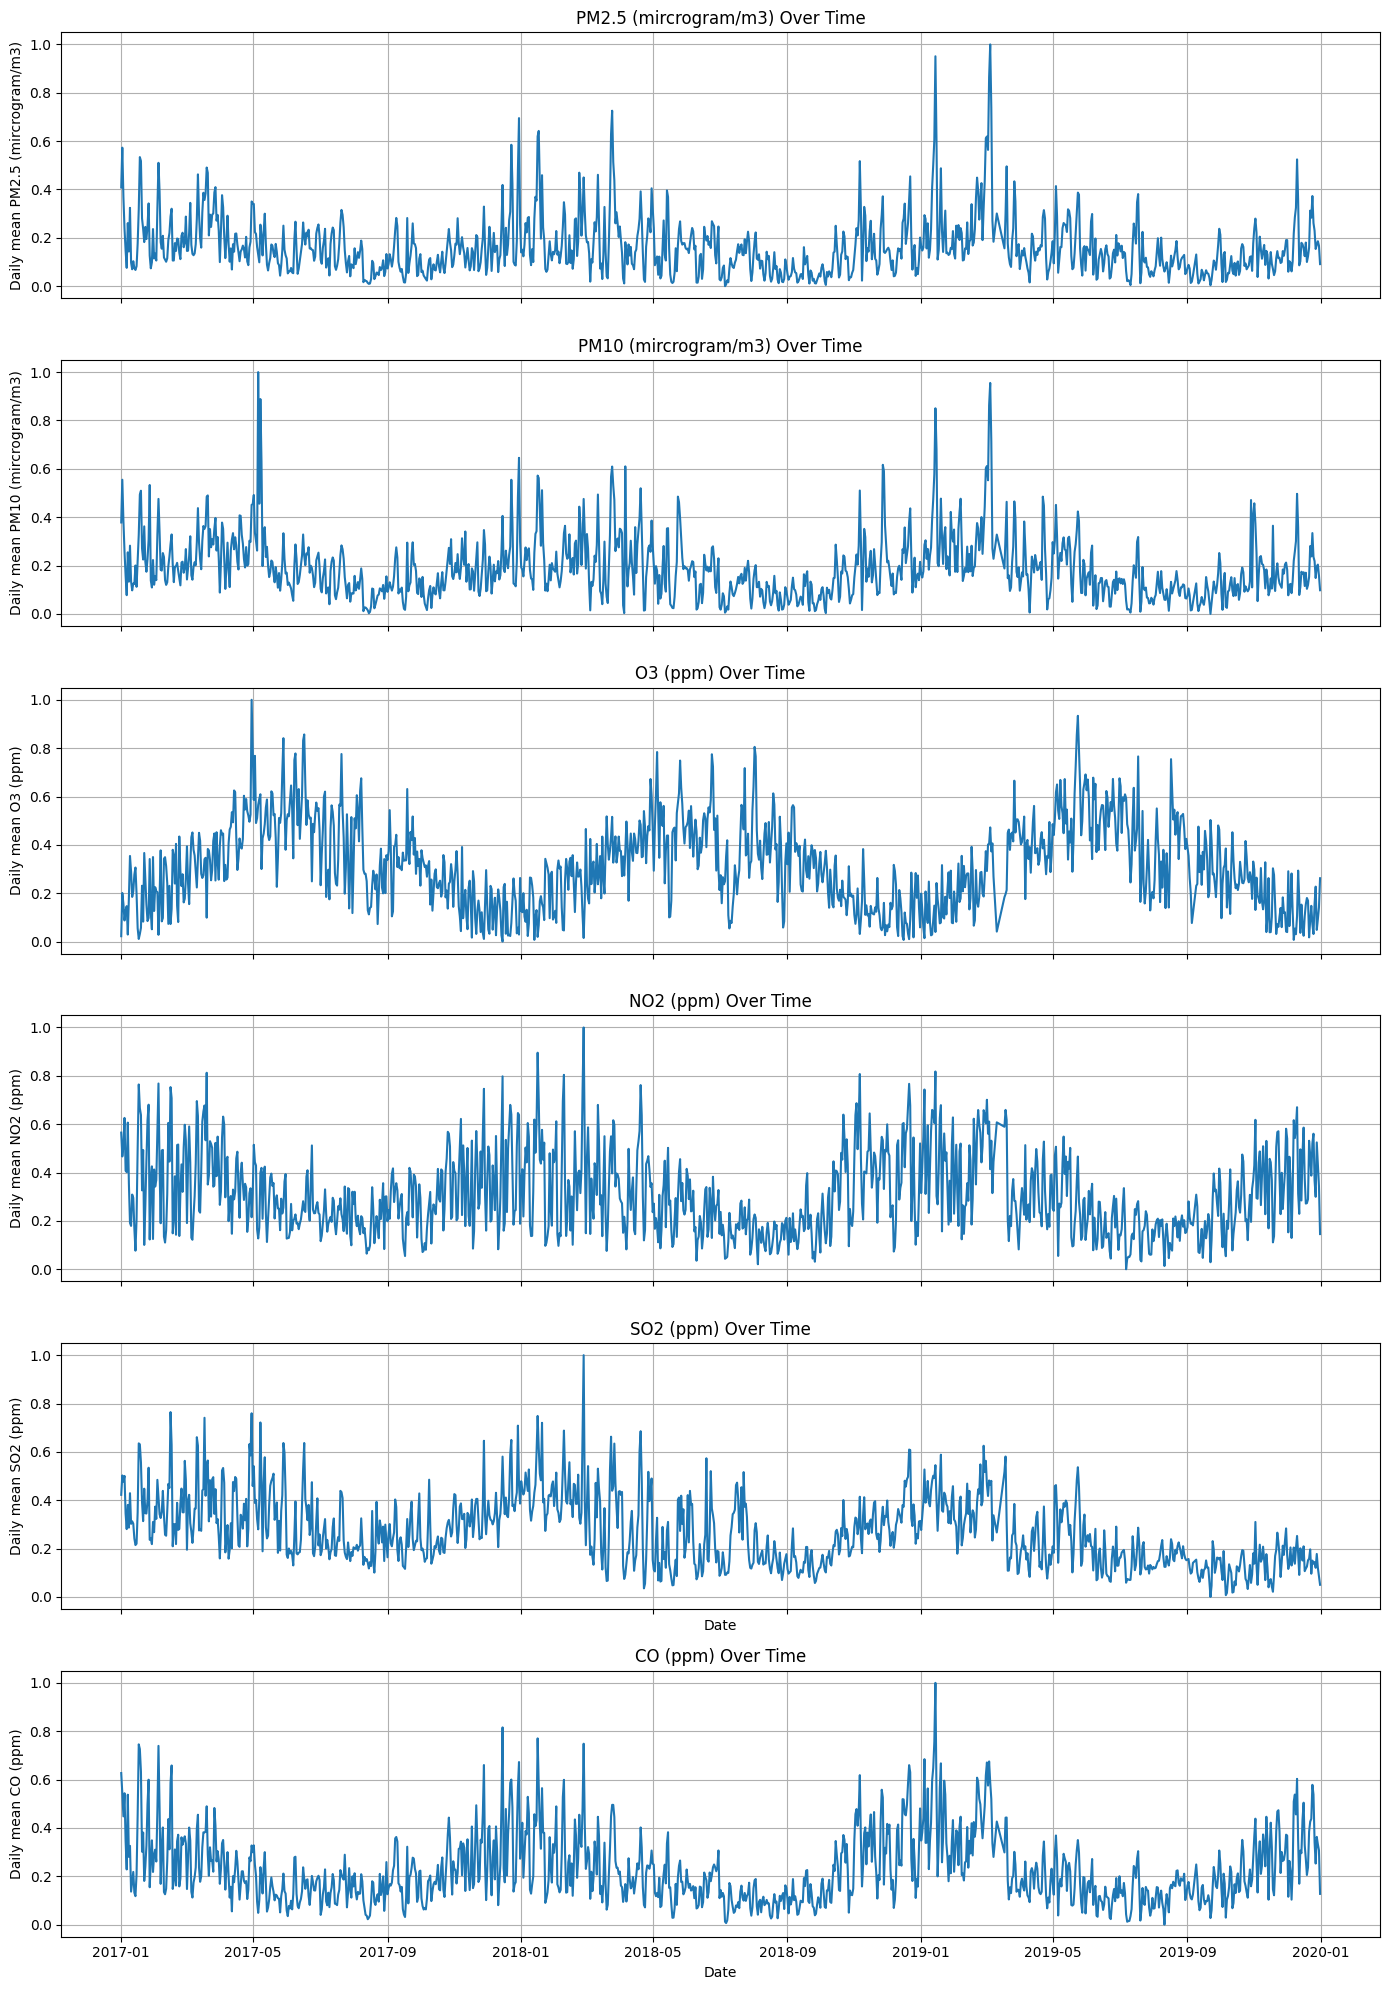

In [ ]:
# Chuẩn bị index
fig = plt.figure(figsize =(10, 12))

pollutants = ["PM2.5 (mircrogram/m3)" , "PM10 (mircrogram/m3)" , "O3 (ppm)" , "NO2 (ppm)" , "SO2 (ppm)" , "CO (ppm)"]

# Lưới 3×2 của chuỗi thời gian
fig, axes = plt.subplots(6, 1, figsize=(14,20), sharex=True)
axes = axes.ravel()

for i, col in enumerate(pollutants):
    axes[i].plot(df2.index, df2[col])
    axes[i].set_title(f"{col} Over Time")
    axes[i].set_ylabel(f"Daily mean {col}")
    if i >= 4:  # only bottom row gets x‐label
        axes[i].set_xlabel("Date")
    axes[i].grid(True)

fig.tight_layout()
plt.show()

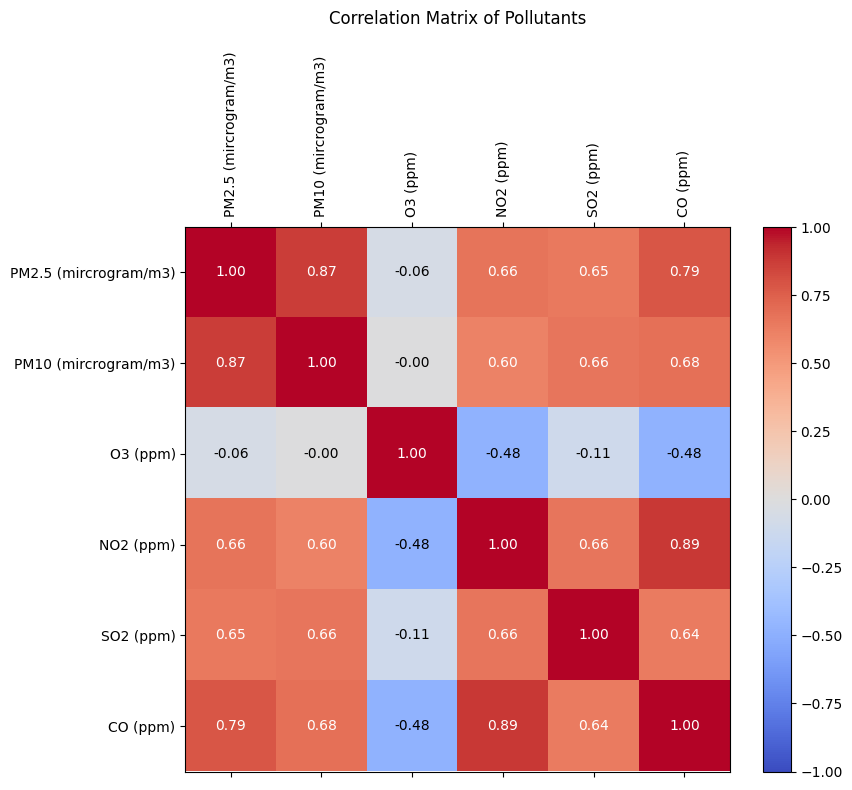

In [ ]:
pollutants = ["PM2.5 (mircrogram/m3)" , "PM10 (mircrogram/m3)" , "O3 (ppm)" , "NO2 (ppm)" , "SO2 (ppm)" , "CO (ppm)"]
corr = df2[pollutants].corr()

fig, ax = plt.subplots(figsize=(10,8))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax, fraction=0.046, pad=0.04)

# đánh dấu nhãn
ax.set_xticks(np.arange(len(pollutants)))
ax.set_yticks(np.arange(len(pollutants)))
ax.set_xticklabels(pollutants, rotation=90)
ax.set_yticklabels(pollutants)

# chú thích từng ô
for i in range(len(pollutants)):
    for j in range(len(pollutants)):
        val = corr.iloc[i, j]
        ax.text(j, i, f"{val:.2f}",
                ha='center', va='center',
                color='white' if abs(val) > 0.5 else 'black')

ax.set_title('Correlation Matrix of Pollutants', pad=20)
plt.tight_layout()
plt.show()

## ARIMA

- Chọn loại ô nhiễm không khí cần dự đoán

In [ ]:
feature_select = "PM10 (mircrogram/m3)"

In [ ]:
# import pandas as pd
# import numpy as np
# from pmdarima import auto_arima
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# df = df2.copy()
# # df.set_index("Measurement date", inplace=True)

# # ————— Chọn chuỗi mục tiêu —————
# y = df[feature_select]

In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = df2.copy()
# df.set_index("Measurement date", inplace=True)

# ————— Chọn chuỗi mục tiêu —————
y = df[feature_select]
y

Date
2017-01-01    0.408268
2017-01-02    0.572920
2017-01-03    0.368448
2017-01-04    0.239163
2017-01-05    0.147568
                ...   
2019-12-27    0.153985
2019-12-28    0.170909
2019-12-29    0.185943
2019-12-30    0.167683
2019-12-31    0.091295
Name: PM2.5 (mircrogram/m3), Length: 1095, dtype: float64

(<Figure size 640x480 with 1 Axes>,)

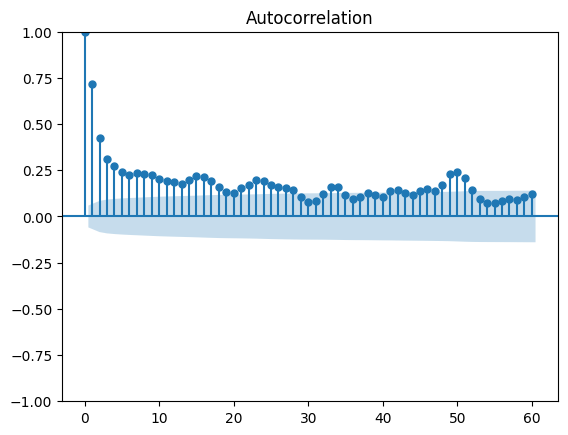

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y, lags=60),

In [ ]:
# ————— Train/test split —————
# 80% train, 20% test
n_train = int(len(y) * 0.8)
train, test = y.iloc[:n_train], y.iloc[n_train:]

# e.g. winsorize at 1st and 99th percentiles
lower, upper = train.quantile([0.01, 0.99])
train_clipped = train.clip(lower, upper)
# candidates = [4, 6, 7, 12]
# results = {}

# for m in candidates:
#     model = auto_arima(
#         train,
#         seasonal=True, m=m,
#         start_p=0, start_q=0, max_p=3, max_q=3,
#         start_P=0, start_Q=0, max_P=2, max_Q=2,
#         d=None, D=None,  # auto difference
#         stepwise=True, trace=False, error_action='ignore',
#         suppress_warnings=True)
#     results[m] = model.aic()

# print("AIC theo từng m:", results)
# best_m = min(results, key=results.get)
# print("→ Chọn m =", best_m, "vì AIC nhỏ nhất")

model = auto_arima(
    train,
    seasonal=True, m=6,
    boxcox=True,           # enable Box–Cox transform
    biasadj=True,          # adjust back-transformed forecast bias
    start_p=0, start_q=0, max_p=5, max_q=5,
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    d=None, D=None,
    stepwise=True, trace=True,
    error_action='ignore', suppress_warnings=True
)
print(model.summary())

# ————— Dự báo trong giai đoạn thử nghiệm —————
n_periods = len(test)
forecast = model.predict(n_periods=n_periods)

# ————— Đánh giá mô hình —————
mse_arima  = mean_squared_error(test, forecast)
mae_arima  = mean_absolute_error(test, forecast)
rmse_arima = np.sqrt(mse_arima)
r2_arima   = r2_score(test, forecast)

print(f"MSE:  {mse_arima:.3f}")
print(f"MAE:  {mae_arima:.3f}")
print(f"RMSE: {rmse_arima:.3f}")
print(f"R²:   {r2_arima:.3f}")


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=-1147.887, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=-1775.966, Time=0.73 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=-1689.789, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=-220.147, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[6] intercept   : AIC=-1777.922, Time=0.15 sec
 ARIMA(1,0,0)(0,0,1)[6] intercept   : AIC=-1775.963, Time=0.60 sec
 ARIMA(1,0,0)(1,0,1)[6] intercept   : AIC=-1774.576, Time=0.72 sec
 ARIMA(2,0,0)(0,0,0)[6] intercept   : AIC=-1808.641, Time=0.27 sec
 ARIMA(2,0,0)(1,0,0)[6] intercept   : AIC=-1806.759, Time=0.77 sec
 ARIMA(2,0,0)(0,0,1)[6] intercept   : AIC=-1806.747, Time=0.60 sec
 ARIMA(2,0,0)(1,0,1)[6] intercept   : AIC=-1809.349, Time=1.27 sec
 ARIMA(2,0,0)(2,0,1)[6] intercept   : AIC=-1808.927, Time=2.65 sec
 ARIMA(2,0,0)(1,0,2)[6] intercept   : AIC=-1808.925, Time=2.63 sec
 ARIMA(2,0,0)(0,0,2)[6] intercept   : AIC=-1807.225, Time=1.40 sec
 ARIMA(2,0,0)(2,0,0)

## Mô hình XGBoost

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = df2.copy()
df = df.sort_index()  # đảm bảo thứ tự thời gian

# ————— Tạo tính năng trễ —————
def make_lagged_df(series, lags):
    """
    Với một pd.Series, trả về một DataFrame với
    các cột: 'y' (mục tiêu) và 'lag_{i}' cho mỗi độ trễ trong độ trễ.
    Xóa các hàng NA được tạo bằng cách dịch chuyển.
    """
    data = pd.DataFrame({'y': series})
    for lag in lags:
        data[f'lag_{lag}'] = series.shift(lag)
    return data.dropna()

# chọn một số độ trễ (ví dụ: 1, 2, 3 ngày nếu theo giờ; hoặc điều chỉnh theo tần suất)
lags = [1, 2, 3, 24, 48, 72]
data = make_lagged_df(df[feature_select], lags)
data

y     lag_1     lag_2     lag_3    lag_24    lag_48  \
Date                                                                     
2017-03-14  0.198595  0.297431  0.462482  0.278631  0.106290  0.248140   
2017-03-15  0.159479  0.198595  0.297431  0.462482  0.178131  0.342327   
2017-03-16  0.305018  0.159479  0.198595  0.297431  0.145866  0.126500   
2017-03-17  0.386445  0.305018  0.159479  0.198595  0.197011  0.073943   
2017-03-18  0.356551  0.386445  0.305018  0.159479  0.195074  0.099138   
...              ...       ...       ...       ...       ...       ...   
2019-12-27  0.153985  0.229303  0.261193  0.372914  0.103605  0.144308   
2019-12-28  0.170909  0.153985  0.229303  0.261193  0.097313  0.170538   
2019-12-29  0.185943  0.170909  0.153985  0.229303  0.061345  0.088008   
2019-12-30  0.167683  0.185943  0.170909  0.153985  0.101646  0.146050   
2019-12-31  0.091295  0.167683  0.185943  0.170909  0.218190  0.130229   

              lag_72  
Date                  
2017-03-14  0.408268  
2017-03-15  0.572920  
2017-03-16  0.368448  
2017-03-17  0.239163  
2017-03-18  0.147568  
...              ...  
2019-12-27  0.090644  
2019-12-28  0.102479  
2019-12-29  0.046784  
2019-12-30  0.062695  
2019-12-31  0.156502  

[1023 rows x 7 columns]

In [ ]:
# ————— Train/test split —————
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test  = data.iloc[train_size:]

X_train = train.drop(columns='y')
y_train = train['y']
X_test  = test.drop(columns='y')
y_test  = test['y']

# ————— Fit XGBoost —————
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)

# ————— Dự báo và đánh giá —————
y_pred = model.predict(X_test)

mse_xgboost  = mean_squared_error(y_test, y_pred)
mae_xgboost  = mean_absolute_error(y_test, y_pred)
rmse_xgboost = np.sqrt(mse_xgboost)
r2_xgboost   = r2_score(y_test, y_pred)

print(f"MSE:  {mse_xgboost:.4f}")
print(f"MAE:  {mae_xgboost:.4f}")
print(f"RMSE: {rmse_xgboost:.4f}")
print(f"R²:   {r2_xgboost:.4f}")

MSE:  0.0041
MAE:  0.0471
RMSE: 0.0643
R²:   0.3145


## LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

df = df2.copy()

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(df[[feature_select]].values)

# Tạo chuỗi cho LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

SEQ_LEN = 60  # ví dụ sử dụng 60 bước trước để dự đoán bước tiếp theo
X, y = create_sequences(scaled, SEQ_LEN)

# định hình lại X thành (mẫu, bước thời gian, tính năng)
X = X.reshape((X.shape[0], X.shape[1], 1))

#  Split into train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

#  Xây dựng mô hình LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LEN,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

#  Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

#  Dự báo trên tập kiểm tra
y_pred_scaled = model.predict(X_test)

#  Đảo ngược tỷ lệ
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred_scaled).flatten()

# Tính toán số liệu
mse_lstm  = mean_squared_error(y_test_inv, y_pred_inv)
mae_lstm  = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm   = r2_score(y_test_inv, y_pred_inv)

print(f"MSE:  {mse_lstm:.4f}")
print(f"MAE:  {mae_lstm:.4f}")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"R²:   {r2_lstm:.4f}")


2025-06-03 04:04:51.519718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748923491.702937      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748923491.755412      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1748923503.970669      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Epoch 1/50


I0000 00:00:1748923508.309372     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0242 - val_loss: 0.0103
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0141 - val_loss: 0.0101
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0124 - val_loss: 0.0104
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0132 - val_loss: 0.0102
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0122 - val_loss: 0.0103
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0140 - val_loss: 0.0103
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0120 - val_loss: 0.0107
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0154 - val_loss: 0.0104
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0130 - val_loss: 0.0105
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0138 - val_loss: 0.0104
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0120 - val_l

## Bi LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

df = df2.copy()

# Chuẩn hóa dữ liệu cột mục tiêu
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(df[[feature_select]].values)

# Tạo chuỗi mô hình BiLSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    X = np.array(X)
    y = np.array(y)
    # reshape X to (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

SEQ_LEN = 60
X, y = create_sequences(scaled, SEQ_LEN)

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Xây dựng mô hình Bidirectional LSTM model
model = Sequential([
    Bidirectional(LSTM(50, return_sequences=True), input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    Bidirectional(LSTM(50)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# Dự báo trên tập kiểm tra
y_pred_scaled = model.predict(X_test)

# Đảo ngược tỷ lệ
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred_scaled).flatten()

# Tính toán số liệu
mse_bilstm  = mean_squared_error(y_test_inv, y_pred_inv)
mae_bilstm  = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_bilstm = np.sqrt(mse_bilstm)
r2_bilstm   = r2_score(y_test_inv, y_pred_inv)

print(f"MSE:  {mse_bilstm:.4f}")
print(f"MAE:  {mae_bilstm:.4f}")
print(f"RMSE: {rmse_bilstm:.4f}")
print(f"R²:   {r2_bilstm:.4f}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0311 - val_loss: 0.0111
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0118 - val_loss: 0.0107
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0119 - val_loss: 0.0104
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0114 - val_loss: 0.0102
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0115 - val_loss: 0.0104
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0108 - val_loss: 0.0102
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0106 - val_loss: 0.0100
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0128 - val_loss: 0.0102
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0110 - val_loss: 0.0103
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0111 - val_loss: 0.0107
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0098 - val_loss: 0.0110
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0116 - val_

## CNN - LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense

df = df2.copy()

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(df[[feature_select]].values)

# Tạo cửa sổ trượt cho CNN‑LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    X = np.array(X)
    y = np.array(y)
    # định hình lại thành[samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

SEQ_LEN = 60  # cửa sổ nhìn lại
X, y = create_sequences(scaled_values, SEQ_LEN)

# Train/Test split (80/20)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Xây dựng mô hình CNN‑LSTM
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu',
           input_shape=(SEQ_LEN, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# Dự đoán trên tập test
y_pred_scaled = model.predict(X_test)

# Đảo ngược tỷ lệ trở lại đơn vị SO2 ban đầu
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred_scaled).flatten()

# Tính toán số liệu đánh giá
mse_cnnlstm  = mean_squared_error(y_test_inv, y_pred_inv)
mae_cnnlstm  = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_cnnlstm = np.sqrt(mse_cnnlstm)
r2_cnnlstm   = r2_score(y_test_inv, y_pred_inv)

print(f"MSE:  {mse_cnnlstm:.4f}")
print(f"MAE:  {mae_cnnlstm:.4f}")
print(f"RMSE: {rmse_cnnlstm:.4f}")
print(f"R²:   {r2_cnnlstm:.4f}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0233 - val_loss: 0.0124
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0135 - val_loss: 0.0106
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0130 - val_loss: 0.0112
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0121 - val_loss: 0.0103
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0135 - val_loss: 0.0106
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0131 - val_loss: 0.0102
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0114 - val_loss: 0.0102
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0123 - val_loss: 0.0101
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0116 - val_loss: 0.0100
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0109 - val_loss: 0.0100
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0100 - val_l

## QPSO-LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

df = df2.copy()

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[[feature_select]].values)

# tạo cửa sổ trượt
def create_sequences(series, seq_len):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i : i + seq_len, 0])
        y.append(series[i + seq_len, 0])
    X = np.array(X)[:, :, None]  # shape (samples, timesteps, features)
    y = np.array(y)
    return X, y

SEQ_LEN = 60
X, y = create_sequences(scaled, SEQ_LEN)

# train/val/test split (60/20/20)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, shuffle=False
)  # 0.25 * 0.8 = 0.2

# Khai báo mô hình
def fitness(hyperparams):
    units = int(hyperparams[0])
    dropout = float(hyperparams[1])
    lr = float(hyperparams[2])

    # build LSTM
    model = Sequential([
        LSTM(units, input_shape=(SEQ_LEN, 1)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    # đào tạo nhanh
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
    # predict & eval
    y_pred = model.predict(X_val).flatten()
    return mean_squared_error(y_val, y_pred)

# Thiết lập PSO lượng tử
n_particles = 10
n_iter = 20
dim = 3  # [units, dropout, lr]
# bounds: units [10,100], dropout [0,0.5], lr [1e-4,1e-2]
lb = np.array([10,   0.0,    1e-4])
ub = np.array([100,  0.5,    1e-2])

# khởi tạo các hạt
X_p = np.random.uniform(lb, ub, (n_particles, dim))
pbest = X_p.copy()
pbest_val = np.array([fitness(p) for p in X_p])
gbest = pbest[np.argmin(pbest_val)].copy()
gbest_val = pbest_val.min()

# Vòng lặp chính QPSO
beta0 = 0.9
for t in range(n_iter):
    beta = beta0 * (1 - t / n_iter)
    mbest = pbest.mean(axis=0)

    for i in range(n_particles):
        u = np.random.rand(dim)
        phi = np.random.rand(dim)
        sign = np.where(np.random.rand(dim) > 0.5, 1, -1)
        X_p[i] = mbest + sign * beta * np.abs(pbest[i] - X_p[i]) * np.log(1.0 / u)
        X_p[i] = np.clip(X_p[i], lb, ub)

        f = fitness(X_p[i])
        if f < pbest_val[i]:
            pbest[i] = X_p[i].copy()
            pbest_val[i] = f
            if f < gbest_val:
                gbest = X_p[i].copy()
                gbest_val = f

print("Best hyperparameters found (units, dropout, lr):", gbest)
print("Validation MSE of best:", gbest_val)

# Huấn luyện lại mô hình cuối cùng và đánh giá trên tập kiểm tra
best_units, best_dropout, best_lr = int(gbest[0]), gbest[1], gbest[2]
final_model = Sequential([
    LSTM(best_units, input_shape=(SEQ_LEN, 1)),
    Dropout(best_dropout),
    Dense(1)
])
final_model.compile(optimizer=Adam(learning_rate=best_lr), loss="mse")
# train on train+val
final_model.fit(X_train_val, y_train_val, epochs=20, batch_size=32, verbose=1)

# dự đoán trên thử nghiệm
y_pred_test = final_model.predict(X_test).flatten()
# đảo ngược tỷ lệ
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred_test.reshape(-1,1)).flatten()

# tính toán số liệu
mse_qpsolstm  = mean_squared_error(y_test_inv, y_pred_inv)
mae_qpsolstm  = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_qpsolstm = np.sqrt(mse_qpsolstm)
r2_qpsolstm   = r2_score(y_test_inv, y_pred_inv)

print(f"\nTest MSE:  {mse_qpsolstm:.4f}")
print(f"Test MAE:  {mae_qpsolstm:.4f}")
print(f"Test RMSE: {rmse_qpsolstm:.4f}")
print(f"Test R²:   {r2_qpsolstm:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Best hyperparameters found (units, dropout, lr): [6.78462259e+01 2.36414880e-01 1.00000000e-02]
Validation MSE of best: 0.01038399397632952
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0231
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0127
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082
Epoch 13/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076
Epoch 14/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066
Epoch 15/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068
Epoch 16/20
26/26 ━━━━━━━━━━━━

## QPSO-BiLSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

df = df2.copy()

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[[feature_select]].values)

# Tạo cửa sổ trượt
def create_sequences(series, seq_len):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i : i + seq_len, 0])
        y.append(series[i + seq_len, 0])
    X = np.array(X)[:, :, None]    # shape (samples, timesteps, features)
    y = np.array(y)
    return X, y

SEQ_LEN = 60
X, y = create_sequences(scaled, SEQ_LEN)

# train/val/test split (60/20/20)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, shuffle=False
)  # 0.25 x 0.8 = 0.2

# Xây dựng mô hình
def fitness(h):
    units  = int(h[0])
    dropout= float(h[1])
    lr     = float(h[2])

    # Mô hình BiLSTM
    model = Sequential([
        Bidirectional(LSTM(units, return_sequences=True), input_shape=(SEQ_LEN,1)),
        Dropout(dropout),
        Bidirectional(LSTM(units)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    # quick train
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
    # eval on validation
    y_pred = model.predict(X_val, verbose=0).flatten()
    return mean_squared_error(y_val, y_pred)

# Thiết lập PSO lượng tử
n_particles = 10
n_iter      = 20
dim         = 3   # [units, dropout, lr]

# bounds: units [10,100], dropout [0,0.5], lr [1e-4,1e-2]
lb = np.array([10,   0.0,    1e-4])
ub = np.array([100,  0.5,    1e-2])

# khởi tạo các hạt
X_p      = np.random.uniform(lb, ub, (n_particles, dim))
pbest    = X_p.copy()
pbest_val= np.array([fitness(p) for p in X_p])
gbest    = pbest[np.argmin(pbest_val)].copy()
gbest_val= pbest_val.min()

beta0 = 0.9
for t in range(n_iter):
    beta = beta0 * (1 - t / n_iter)
    mbest = pbest.mean(axis=0)
    for i in range(n_particles):
        u    = np.random.rand(dim)
        sign = np.where(np.random.rand(dim)>0.5, 1, -1)
        # quantum-behaved update
        X_p[i] = mbest + sign * beta * np.abs(pbest[i] - X_p[i]) * np.log(1.0/u)
        X_p[i] = np.clip(X_p[i], lb, ub)
        f = fitness(X_p[i])
        if f < pbest_val[i]:
            pbest[i]     = X_p[i].copy()
            pbest_val[i] = f
            if f < gbest_val:
                gbest     = X_p[i].copy()
                gbest_val = f

print("Best hyperparameters (units, dropout, lr):", gbest)
print("Validation MSE:", gbest_val)

# Đào tạo lại mô hình cuối cùng và đánh giá trên bộ thử nghiệm
best_units, best_dropout, best_lr = int(gbest[0]), gbest[1], gbest[2]

final_model = Sequential([
    Bidirectional(LSTM(best_units, return_sequences=True), input_shape=(SEQ_LEN,1)),
    Dropout(best_dropout),
    Bidirectional(LSTM(best_units)),
    Dropout(best_dropout),
    Dense(1)
])
final_model.compile(optimizer=Adam(learning_rate=best_lr), loss='mse')

# tàu trên tàu+val
final_model.fit(X_train_val, y_train_val, epochs=20, batch_size=32, verbose=1)

# Dự đoán trên tập test
y_pred_test = final_model.predict(X_test).flatten()

# Đảo ngược
y_test_inv  = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv  = scaler.inverse_transform(y_pred_test.reshape(-1,1)).flatten()

# Tính toán giá trị đánh giá
mse_qpsobilstm  = mean_squared_error(y_test_inv, y_pred_inv)
mae_qpsobilstm  = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_qpsobilstm = np.sqrt(mse_qpsobilstm)
r2_qpsobilstm   = r2_score(y_test_inv, y_pred_inv)

print(f"\nTest MSE:  {mse_qpsobilstm:.4f}")
print(f"Test MAE:  {mae_qpsobilstm:.4f}")
print(f"Test RMSE: {rmse_qpsobilstm:.4f}")
print(f"Test R²:   {r2_qpsobilstm:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `

Best hyperparameters (units, dropout, lr): [5.81348996e+01 2.71287308e-01 5.27071519e-03]
Validation MSE: 0.01232333407195487
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0277
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0111
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0113
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0101
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0100
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0091
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0086
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0088
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0091
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0082
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0079
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0075
Epoch 13/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0072
Epoch 14/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0083
Epoch 15/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0072
Epoch 16/20
26/

## Proposal Method Paper

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
# time‑series ARIMA
from pmdarima import auto_arima

# CNN‑LSTM and QPSO
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Dropout, LSTM, Dense,
    Input, Activation, Multiply, Permute, Lambda, Softmax
)
from tensorflow.keras.optimizers import Adam

# XGBoost meta‑learner
from xgboost import XGBRegressor

# metrics & preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# ————————————— Chuẩn bị dữ liệu —————————————
df = df2.copy()

df = df.sort_index()

series = df[feature_select].values
dates  = df.index

# train/test split
n = len(series)
split_idx = int(n * 0.8)
y_train = series[:split_idx]
y_test  = series[split_idx:]
n_test  = len(y_test)

# ————————————— Mô hình ARIMA —————————————
arima = auto_arima(
    y_train,
    seasonal=False,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

# Dự đoán tập train với arima
arima_train_pred = arima.predict_in_sample()

# dự báo thử nghiệm ngoài mẫu
arima_test_pred  = arima.predict(n_periods=n_test)

# kết hợp cho "tất cả" các dự đoán được căn chỉnh theo bản gốc
arima_pred_all = np.concatenate([arima_train_pred, arima_test_pred])

# chuỗi dư = thực tế − arima_pred
resid_all = series - arima_pred_all

# ————————————— XÂY DỰNG CỬA SỔ TRƯỢT —————————————
SEQ_LEN = 48  #Supervised Learning

def make_windows(x, seq_len):
    X, y = [], []
    for i in range(len(x) - seq_len):
        X.append(x[i : i + seq_len])
        y.append(x[i + seq_len])
    X = np.array(X)[:, :, None]  # shape=(samples, timesteps, 1)
    y = np.array(y)
    return X, y

X_resid, y_resid = make_windows(resid_all, SEQ_LEN)

# tìm ra cửa sổ nào được đào tạo so với cửa sổ nào được kiểm tra theo thời gian mục tiêu của chúng
# cửa sổ i có mục tiêu tại chỉ mục gốc i+SEQ_LEN
train_mask = (np.arange(len(X_resid)) + SEQ_LEN) < split_idx
test_mask  = (np.arange(len(X_resid)) + SEQ_LEN) >= split_idx

X_r_train = X_resid[train_mask]
y_r_train = y_resid[train_mask]
X_r_test  = X_resid[test_mask]
y_r_test  = y_resid[test_mask]

# further split X_r_train into train/val for QPSO
X_r_tr, X_r_val, y_r_tr, y_r_val = train_test_split(
    X_r_train, y_r_train, test_size=0.2, shuffle=False
)

# ————————————— ATTENTION‑CNN + QPSO‑LSTM FOR RESIDUALS —————————————

# khối tự chú ý đơn giản sau Conv1D
def attention_block(x):
    # x: (batch, timesteps, channels)
    a = Permute((2, 1))(x)                      # (batch, channels, timesteps)
    a = Dense(x.shape[1], activation='softmax')(a)
    a = Permute((2, 1))(a)                      # (batch, timesteps, channels)
    return Multiply()([x, a])                  # áp trọng số chú ý

def build_cnn_lstm(units=64, dropout=0.2, lr=1e-3):
    inp = Input(shape=(SEQ_LEN, 1))
    x   = Conv1D(32, 3, activation='relu', padding='same')(inp)
    x   = MaxPooling1D(2)(x)
    x   = attention_block(x)
    x   = LSTM(units)(x)
    x   = Dropout(dropout)(x)
    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out, name="CNN_LSTM")
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

# Tìm kiếm siêu tham số QPSO trên [đơn vị, bỏ qua, lr]
def fitness(p):
    u = int(p[0])
    d = float(p[1])
    l = float(p[2])
    m = build_cnn_lstm(u, d, l)
    m.fit(X_r_tr, y_r_tr, epochs=3, batch_size=32, verbose=0)
    pred = m.predict(X_r_val, verbose=0).flatten()
    return mean_squared_error(y_r_val, pred)

# QPSO setup
n_particles, n_iter = 8, 15
dim = 3
lb = np.array([10, 0.0, 1e-4])
ub = np.array([100, 0.5, 1e-2])

# initialize
X_p = np.random.uniform(lb, ub, (n_particles, dim))
pbest = X_p.copy()
pbest_val = np.array([fitness(p) for p in X_p])
gbest = pbest[np.argmin(pbest_val)].copy()
gbest_val = pbest_val.min()

beta0 = 0.9
for t in range(n_iter):
    beta = beta0 * (1 - t/n_iter)
    mbest = pbest.mean(axis=0)
    for i in range(n_particles):
        u_rand   = np.random.rand(dim)
        sign     = np.where(np.random.rand(dim)>0.5, 1, -1)
        X_p[i]   = mbest + sign * beta * np.abs(pbest[i]-X_p[i]) * np.log(1.0/u_rand)
        X_p[i]   = np.clip(X_p[i], lb, ub)
        f_val    = fitness(X_p[i])
        if f_val < pbest_val[i]:
            pbest[i]     = X_p[i].copy()
            pbest_val[i] = f_val
            if f_val < gbest_val:
                gbest     = X_p[i].copy()
                gbest_val = f_val

best_units, best_dropout, best_lr = int(gbest[0]), gbest[1], gbest[2]
print("QPSO best [units,dropout,lr]:", gbest)

# đào tạo mô hình dư thừa cuối cùng trên X_r_train đầy đủ
resid_model = build_cnn_lstm(best_units, best_dropout, best_lr)
resid_model.fit(X_r_train, y_r_train, epochs=20, batch_size=32, verbose=1)

# dự đoán các giá trị còn lại trên cửa sổ đào tạo/kiểm tra
resid_pred_train = resid_model.predict(X_r_train).flatten()
resid_pred_test  = resid_model.predict(X_r_test).flatten()

# ————————————— XGBOOST META‑LEARNER —————————————
# lắp ráp các tính năng meta: [ARIMA_pred, CNN‑LSTM_resid_pred]
idx_r_train = np.where(train_mask)[0]
idx_r_test  = np.where(test_mask )[0]

t_idx_train = idx_r_train + SEQ_LEN
t_idx_test  = idx_r_test  + SEQ_LEN

# các tính năng siêu dữ liệu và mục tiêu
X_meta_train = np.vstack([
    arima_pred_all[t_idx_train],
    resid_pred_train
]).T
y_meta_train = series[t_idx_train]

X_meta_test  = np.vstack([
    arima_pred_all[t_idx_test],
    resid_pred_test
]).T
y_meta_test  = series[t_idx_test]

meta = XGBRegressor(objective='reg:squarederror', random_state=42)
meta.fit(X_meta_train, y_meta_train)

final_pred = meta.predict(X_meta_test)

# ————————————— Đánh giá mô hình —————————————
mse_proposal   = mean_squared_error(y_meta_test, final_pred)
mae_proposal   = mean_absolute_error(y_meta_test, final_pred)
rmse_proposal  = np.sqrt(mse_proposal)
r2_proposal    = r2_score(y_meta_test, final_pred)

print(f"\nFINAL Test MSE:  {mse_proposal:.4f}")
print(f"      Test MAE:  {mae_proposal:.4f}")
print(f"      Test RMSE: {rmse_proposal:.4f}")
print(f"      Test R²:   {r2_proposal:.4f}")


QPSO best [units,dropout,lr]: [5.70086177e+01 1.79897026e-01 7.32209686e-03]
Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0073
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079
Epoch 13/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073
Epoch 14/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064
Epoch 15

## Transformer

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

df = df2.copy()

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled  = scaler.fit_transform(df[[feature_select]].values)

# Tạp chuỗi sequences
def create_sequences(data, seq_length: int):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

SEQ_LEN = 60
X, y = create_sequences(scaled, SEQ_LEN)
X = X.reshape((X.shape[0], X.shape[1], 1))   # (samples, timesteps, features)

#  Phân tách dữ liệu train / test
split = int(0.8 * len(X))
X_train, X_test = X[:split],  X[split:]
y_train, y_test = y[:split],  y[split:]

# mã hóa vị trí
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pos = np.arange(max_len)[:, None]
        i   = np.arange(d_model)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angle_rads  = pos * angle_rates
        pe = np.zeros((max_len, d_model))
        pe[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pe[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pe = tf.cast(pe[None, ...], tf.float32)   # shape (1, max_len, d_model)

    def call(self, x):
        return x + self.pe[:, :tf.shape(x)[1], :]

#  Transformer model
def build_transformer(seq_len, d_model=64, num_heads=4, ff_dim=128, num_layers=2, dropout=0.2):
    inp = layers.Input(shape=(seq_len, 1))

    # Phép chiếu tuyến tính từ 1 tính năng → d_model
    x = layers.Dense(d_model)(inp)

    # Thêm thông tin vị trí
    x = PositionalEncoding(d_model)(x)

    # Các lớp mã hóa Stack Transformer
    for _ in range(num_layers):
        # Khối tự chú ý nhiều đầu - Multi Head Attention
        attn_out = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=d_model,
                                             dropout=dropout)(x, x)
        x = layers.Add()([x, attn_out])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Khối truyền thẳng - Feed Forward
        ffn = layers.Dense(ff_dim, activation='relu')(x)
        ffn = layers.Dense(d_model)(ffn)
        x   = layers.Add()([x, ffn])
        x   = layers.LayerNormalization(epsilon=1e-6)(x)

    # Gộp theo thời gian → vectơ đơn
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)

    # Đầu hồi quy
    out = layers.Dense(1)(x)

    return models.Model(inp, out)

model = build_transformer(SEQ_LEN)
model.compile(optimizer='adam', loss='mse')
model.summary()

# Huấn luyện
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Suy luận & nghịch đảo
y_pred_scaled = model.predict(X_test, verbose=0)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred_scaled).flatten()

# Đánh giá
mse_trans  = mean_squared_error(y_test_inv, y_pred_inv)
mae_trans  = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_trans = np.sqrt(mse_trans)
r2_trans   = r2_score(y_test_inv, y_pred_inv)

print(f"MSE:  {mse_trans:.4f}")
print(f"MAE:  {mae_trans:.4f}")
print(f"RMSE: {rmse_trans:.4f}")
print(f"R²:   {r2_trans:.4f}")

Model: "functional_425"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_554           │ (None, 60, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_683 (Dense)         │ (None, 60, 64)         │            128 │ input_layer_554[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_encoding       │ (None, 60, 64)         │              0 │ dense_683[0][0]        │
│ (PositionalEncoding)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 60, 64)         │         66,368 │ positional_encoding[0… │
│ (MultiHeadAttention)      │                        │                │ positional_encoding[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 60, 64)         │              0 │ positional_encoding[0… │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 60, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_684 (Dense)         │ (None, 60, 128)        │          8,320 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_685 (Dense)         │ (None, 60, 64)         │          8,256 │ dense_684[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 60, 64)         │              0 │ layer_normalization[0… │
│                           │                        │                │ dense_685[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 60, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 60, 64)         │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 60, 64)         │              0 │ layer_normalization_1… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 60, 64)         │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_686 (Dense)         │ (None, 60, 128)        │          8,320 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_687 (Dense)    

 Total params: 166,593 (650.75 KB)

 Trainable params: 166,593 (650.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1748926279.622829     119 service.cc:148] XLA service 0x53e33930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748926279.623527     119 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7503 

I0000 00:00:1748926284.358055     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 259ms/step - loss: 1.6959 - val_loss: 0.1482
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3221 - val_loss: 0.0181
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1022 - val_loss: 0.0104
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0470 - val_loss: 0.0132
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0302 - val_loss: 0.0123
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0332 - val_loss: 0.0132
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0227 - val_loss: 0.0187
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0230 - val_loss: 0.0123
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0181 - val_loss: 0.0150
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0162 - val_loss: 0.0147
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0184 - val_loss: 0.0199
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0300 - val

In [ ]:
import pandas as pd

# Tạo dict chứa các báo cáo cho mỗi mô hình
data = {
    "ARIMA": {
        "MSE":  mse_arima,
        "MAE":  mae_arima,
        "RMSE": rmse_arima,
        "R2":   r2_arima
    },
    "XGBoost": {
        "MSE":  mse_xgboost,
        "MAE":  mae_xgboost,
        "RMSE": rmse_xgboost,
        "R2":   r2_xgboost
    },
    "LSTM": {
        "MSE":  mse_lstm,
        "MAE":  mae_lstm,
        "RMSE": rmse_lstm,
        "R2":   r2_lstm
    },
    "BiLSTM": {
        "MSE":  mse_bilstm,
        "MAE":  mae_bilstm,
        "RMSE": rmse_bilstm,
        "R2":   r2_bilstm
    },
    "CNN-LSTM": {
        "MSE":  mse_cnnlstm,
        "MAE":  mae_cnnlstm,
        "RMSE": rmse_cnnlstm,
        "R2":   r2_cnnlstm
    },
    "QPSO-LSTM": {
        "MSE":  mse_qpsolstm,
        "MAE":  mae_qpsolstm,
        "RMSE": rmse_qpsolstm,
        "R2":   r2_qpsolstm
    },
    "QPSO-BiLSTM": {
        "MSE":  mse_qpsobilstm,
        "MAE":  mae_qpsobilstm,
        "RMSE": rmse_qpsobilstm,
        "R2":   r2_qpsobilstm
    },
    "Proposed": {
        "MSE":  mse_proposal,
        "MAE":  mae_proposal,
        "RMSE": rmse_proposal,
        "R2":   r2_proposal
    },
    "Transformer": {
        "MSE":  mse_trans,
        "MAE":  mae_trans,
        "RMSE": rmse_trans,
        "R2":   r2_trans
    }
}

# Chuyển thành DataFrame, mỗi hàng là một mô hình
results_df = pd.DataFrame(data).T.reset_index()
results_df.columns = ["Model", "MSE", "MAE", "RMSE", "R2"]

print(results_df)


         Model       MSE       MAE      RMSE        R2
0        ARIMA  0.009154  0.081042  0.095675 -0.520698
1      XGBoost  0.004129  0.047077  0.064253  0.314543
2         LSTM  0.003480  0.043809  0.058993  0.419676
3       BiLSTM  0.003712  0.045288  0.060922  0.381087
4     CNN-LSTM  0.003793  0.045061  0.061591  0.367434
5    QPSO-LSTM  0.003451  0.043676  0.058741  0.424607
6  QPSO-BiLSTM  0.003460  0.044329  0.058822  0.423024
7     Proposed  0.019347  0.116537  0.139094 -2.214102
8  Transformer  0.003586  0.044077  0.059887  0.401951


In [ ]:
results_df

Model       MSE       MAE      RMSE        R2
0        ARIMA  0.009154  0.081042  0.095675 -0.520698
1      XGBoost  0.004129  0.047077  0.064253  0.314543
2         LSTM  0.003480  0.043809  0.058993  0.419676
3       BiLSTM  0.003712  0.045288  0.060922  0.381087
4     CNN-LSTM  0.003793  0.045061  0.061591  0.367434
5    QPSO-LSTM  0.003451  0.043676  0.058741  0.424607
6  QPSO-BiLSTM  0.003460  0.044329  0.058822  0.423024
7     Proposed  0.019347  0.116537  0.139094 -2.214102
8  Transformer  0.003586  0.044077  0.059887  0.401951